# Домашнее задание 1

In [160]:
!pip install catboost -q

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL, MSTL
import datetime
import holidays
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xml.etree.ElementTree as ET
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostRegressor
from IPython.display import clear_output
from sklearn.metrics import make_scorer
from sktime.utils.plotting import plot_series
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings("ignore")


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями. 

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день.

#### Описание бизнес-процесса, связанного с рядом.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Но ими также могут быть ценные бумаги крупных компаний и деривативы на них. Для банков важно поддерживать некоторый уровень ликвидности, чтобы всегда иметь возможность либо быстро отдать краткосрочные долги. Крупнейшие банковские кризисы во многом состоялись из-за набега вкладчиков, забравших свои деньги, из-за чего банки не могли в моменте обслуживать свои займы. Ликвидные активы можно быстро вложить, если на рынке встретились хорошие условия. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Мы хотим прогнозировать сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 


## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Вам необходимо определить частоту данных, так как от этого будут зависеть параметры модели. Исходя из частоты выберите оффсет [Оффсет](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).Не спешите отвечать на этот вопрос и посмотрите на данные **внимательно**. Сделайте ресэмпл ряда к выбранному оффсету. Если вы всё сделали правильно, то дисперсия ряда должна быть примерно одинаковой на любом участке.

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

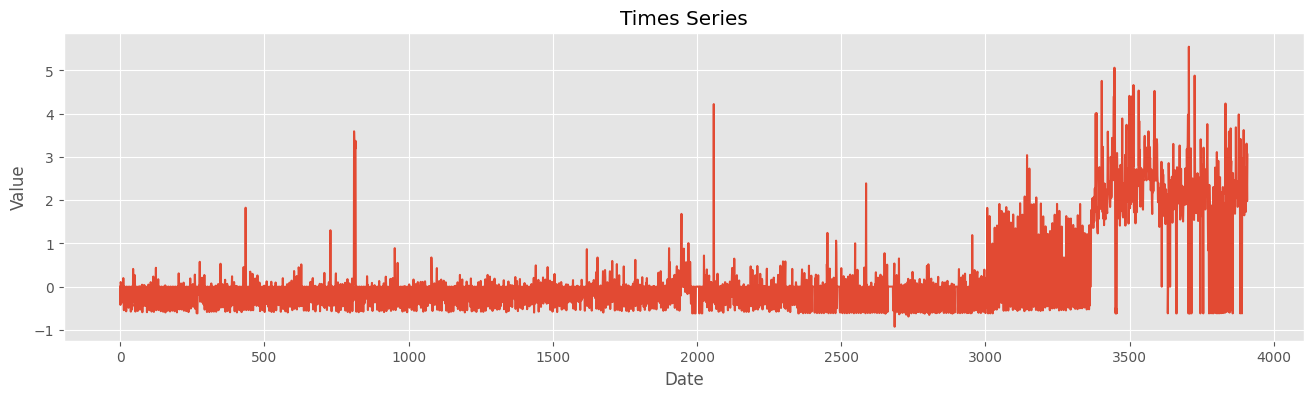

In [5]:
plt.figure(figsize = (16, 4))
plt.plot(data.Target)
plt.title('Times Series')
plt.xlabel('Date')
plt.ylabel('Value');

In [6]:
sample = data.groupby(by = 'Date').sum()

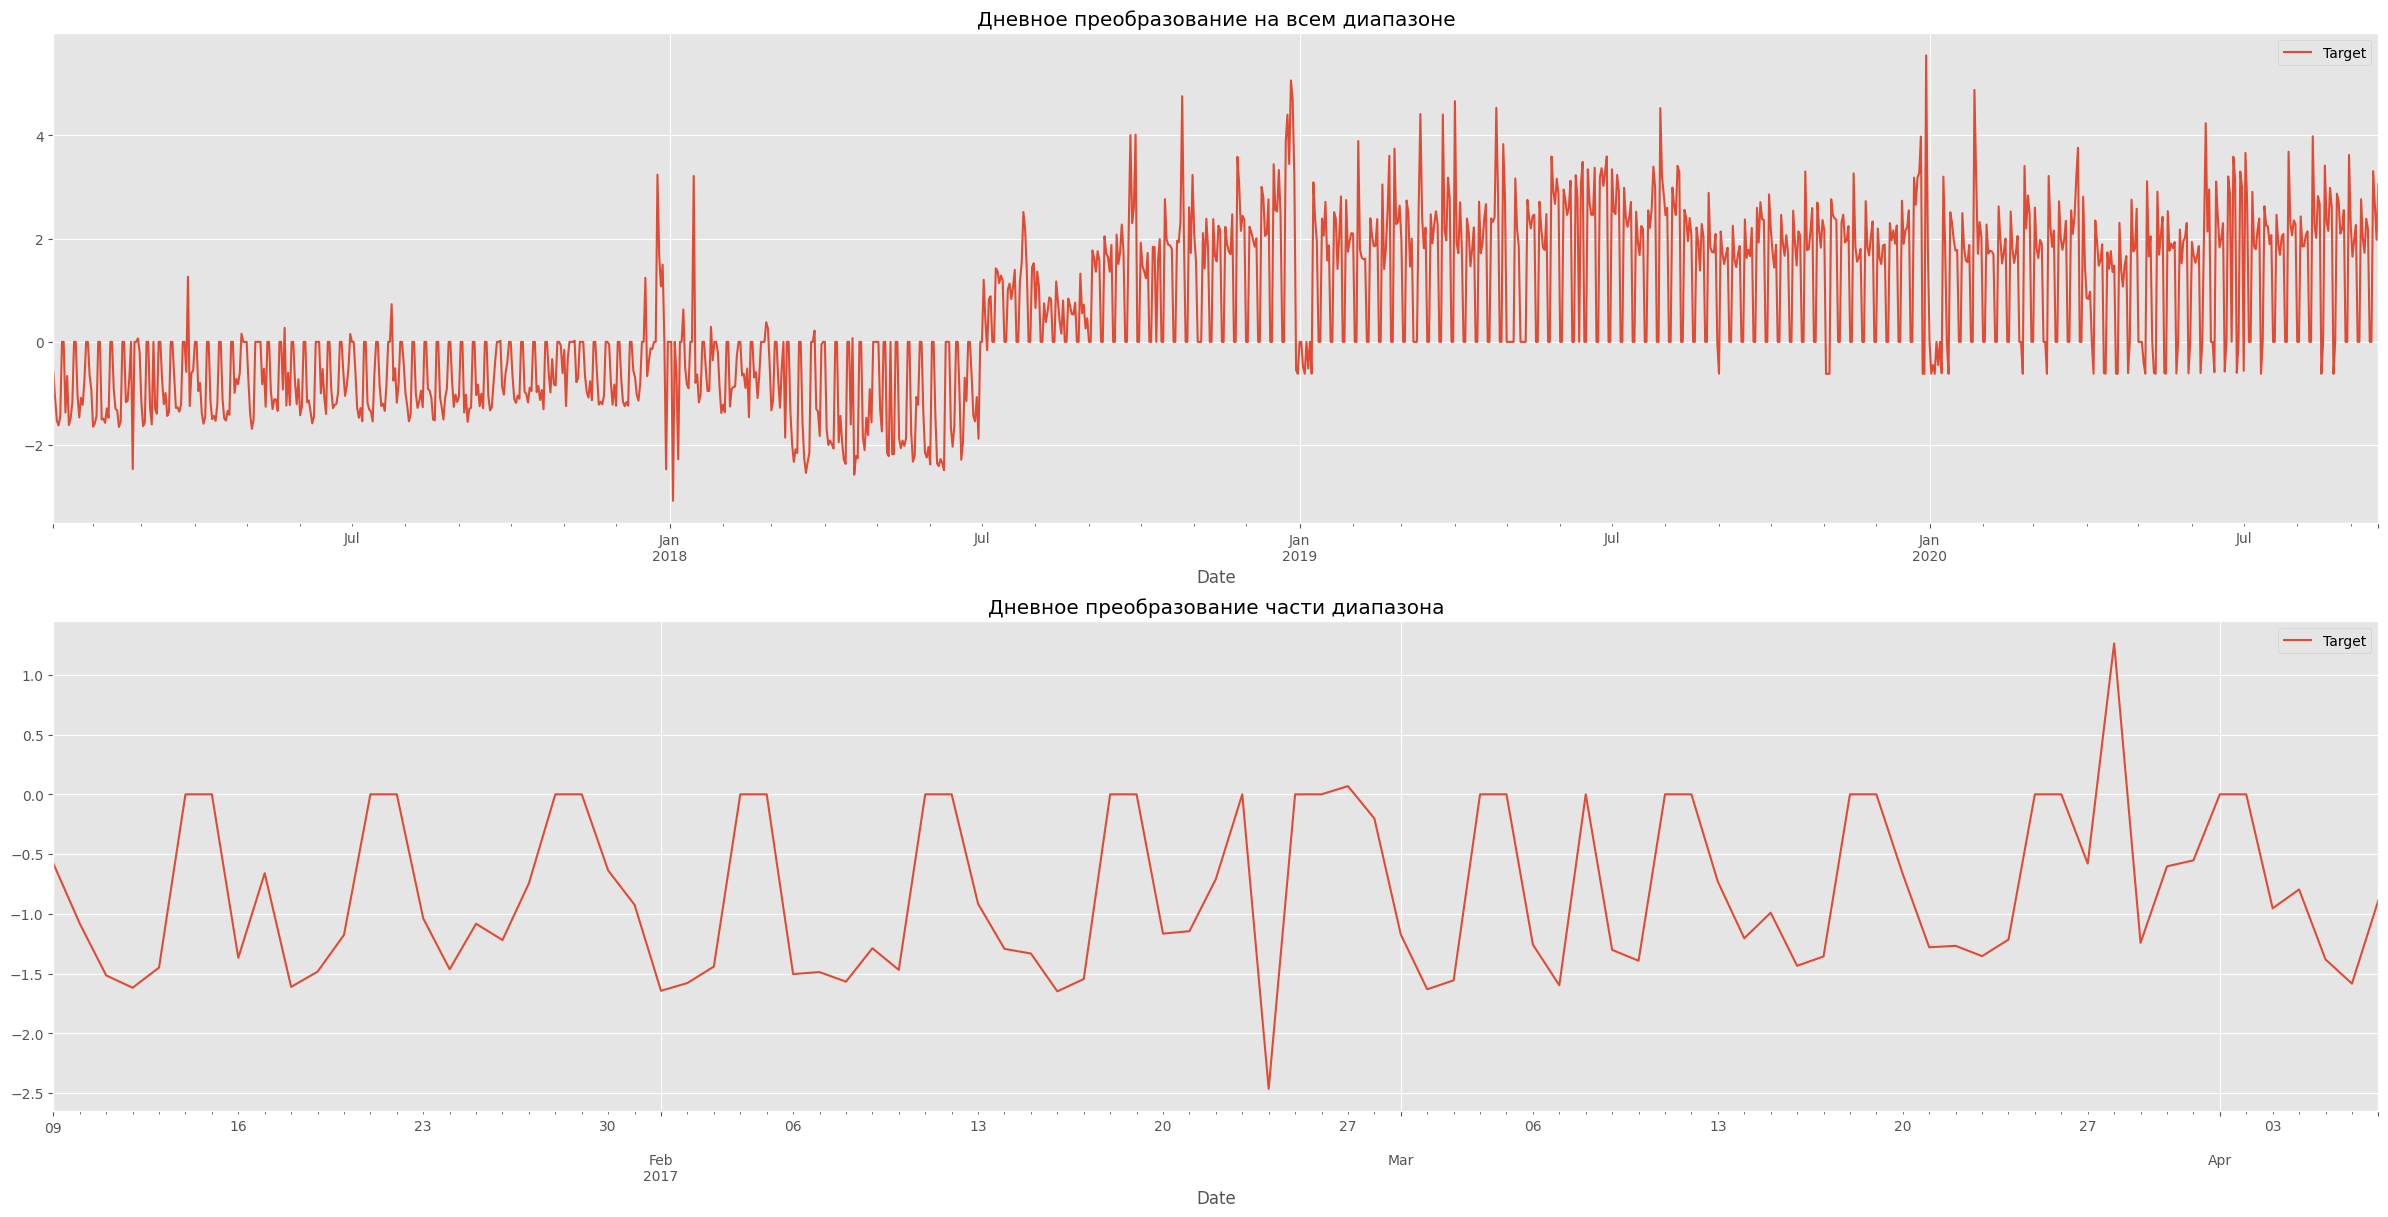

In [7]:
fig, axs = plt.subplots(2, 1, figsize = (30, 14))
sample.resample('D').sum().plot(ax = axs[0])
axs[0].set_title('Дневное преобразование на всем диапазоне');
sample[:500].resample('D').sum().plot(ax = axs[1])
axs[1].set_title('Дневное преобразование части диапазона');

Как можно видеть, периодичность больше похожа на дневную, при этом виден явный сдвиг в июле

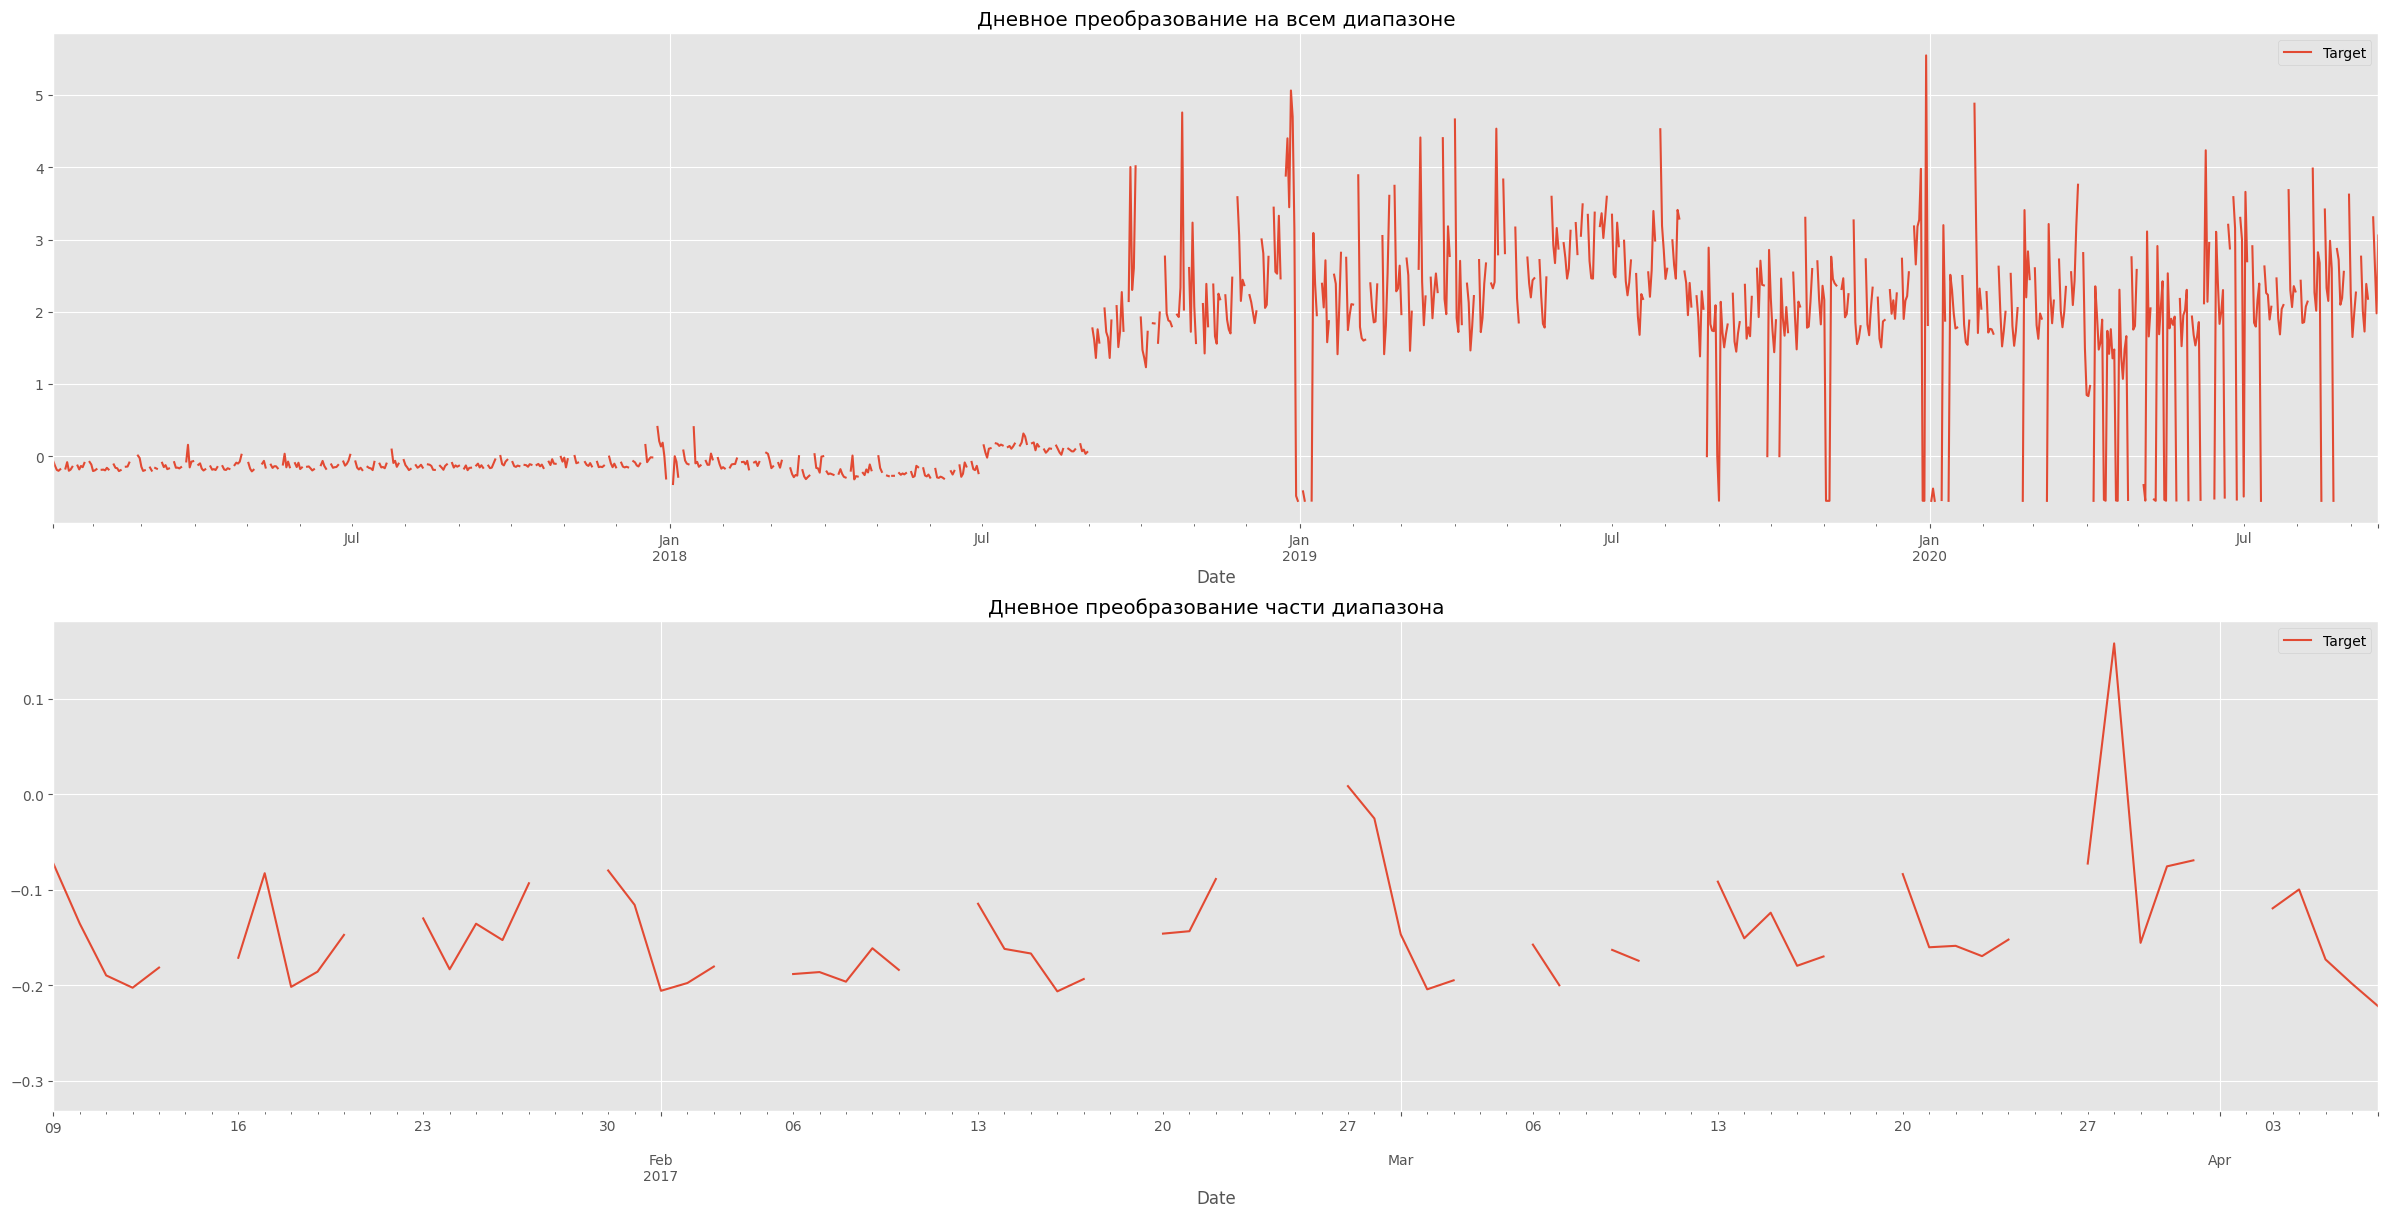

In [8]:
fig, axs = plt.subplots(2, 1, figsize = (30, 14))
sample.resample('D').mean().plot(ax = axs[0])
axs[0].set_title('Дневное преобразование на всем диапазоне');
sample[:500].resample('D').mean().plot(ax = axs[1])
axs[1].set_title('Дневное преобразование части диапазона');

При этом пропущены значения в выходные дни

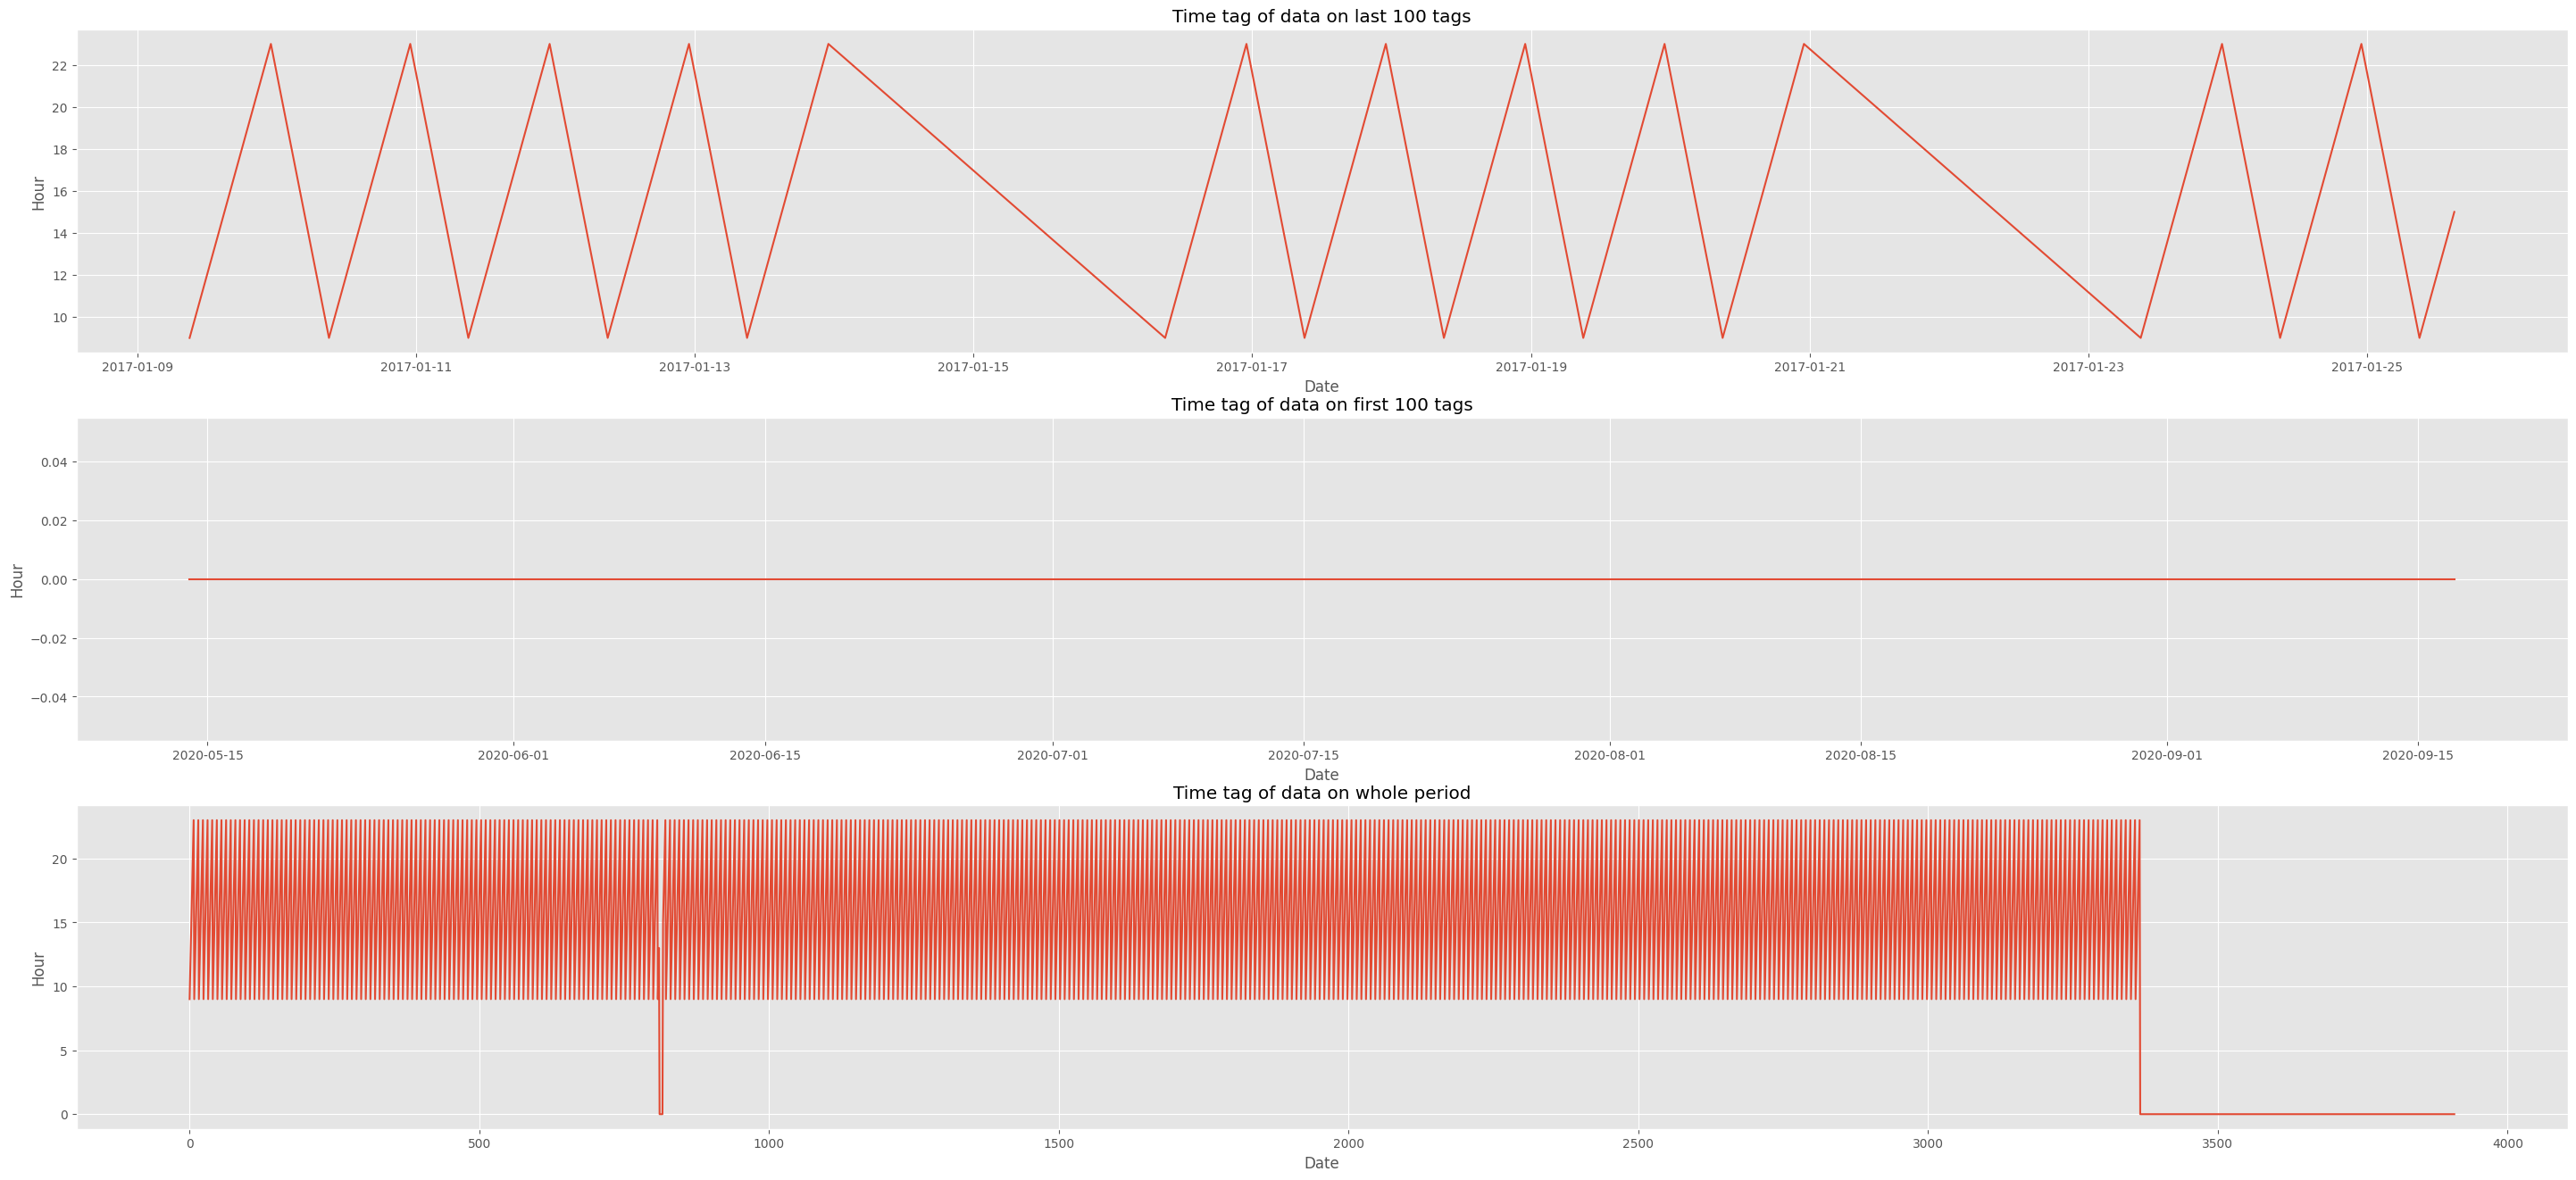

In [9]:
fig, axs = plt.subplots(3, 1, figsize = (36, 16))
axs[0].plot(data.Date[:100], data.Date.dt.hour[:100])
axs[1].plot(data.Date[-100:], data.Date.dt.hour[-100:])
axs[2].plot( data.Date.dt.hour)
for i in range(3):
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Hour')
    axs[i].set_title('Time tag of data on ' + (i == 2) * 'whole period' + (i == 1) * 'first 100 tags' + (i == 0) * 'last 100 tags' )
    ;

Если посмотреть на почасовые разметки, то видно, что сначала стата снималась каждые два за день с 9 до 23, а потом начала сниматься один раз в день в 0 часов

Просуммируем значения в течение дня

In [10]:
data['date'] = data.Date.dt.date
data

Date    Target        date
0    2017-01-09 09:00:00  0.000000  2017-01-09
1    2017-01-09 11:00:00 -0.421841  2017-01-09
2    2017-01-09 13:00:00  0.105555  2017-01-09
3    2017-01-09 15:00:00  0.042276  2017-01-09
4    2017-01-09 17:00:00  0.071416  2017-01-09
...                  ...       ...         ...
3904 2020-09-11 00:00:00  2.180332  2020-09-11
3905 2020-09-14 00:00:00  3.307929  2020-09-14
3906 2020-09-15 00:00:00  2.644602  2020-09-15
3907 2020-09-16 00:00:00  1.977839  2020-09-16
3908 2020-09-17 00:00:00  3.056148  2020-09-17

[3909 rows x 3 columns]

In [11]:
data_date = pd.Series(data.groupby(by = 'date')['Target'].sum()).reset_index()
data_date.date = pd.to_datetime(data_date.date)

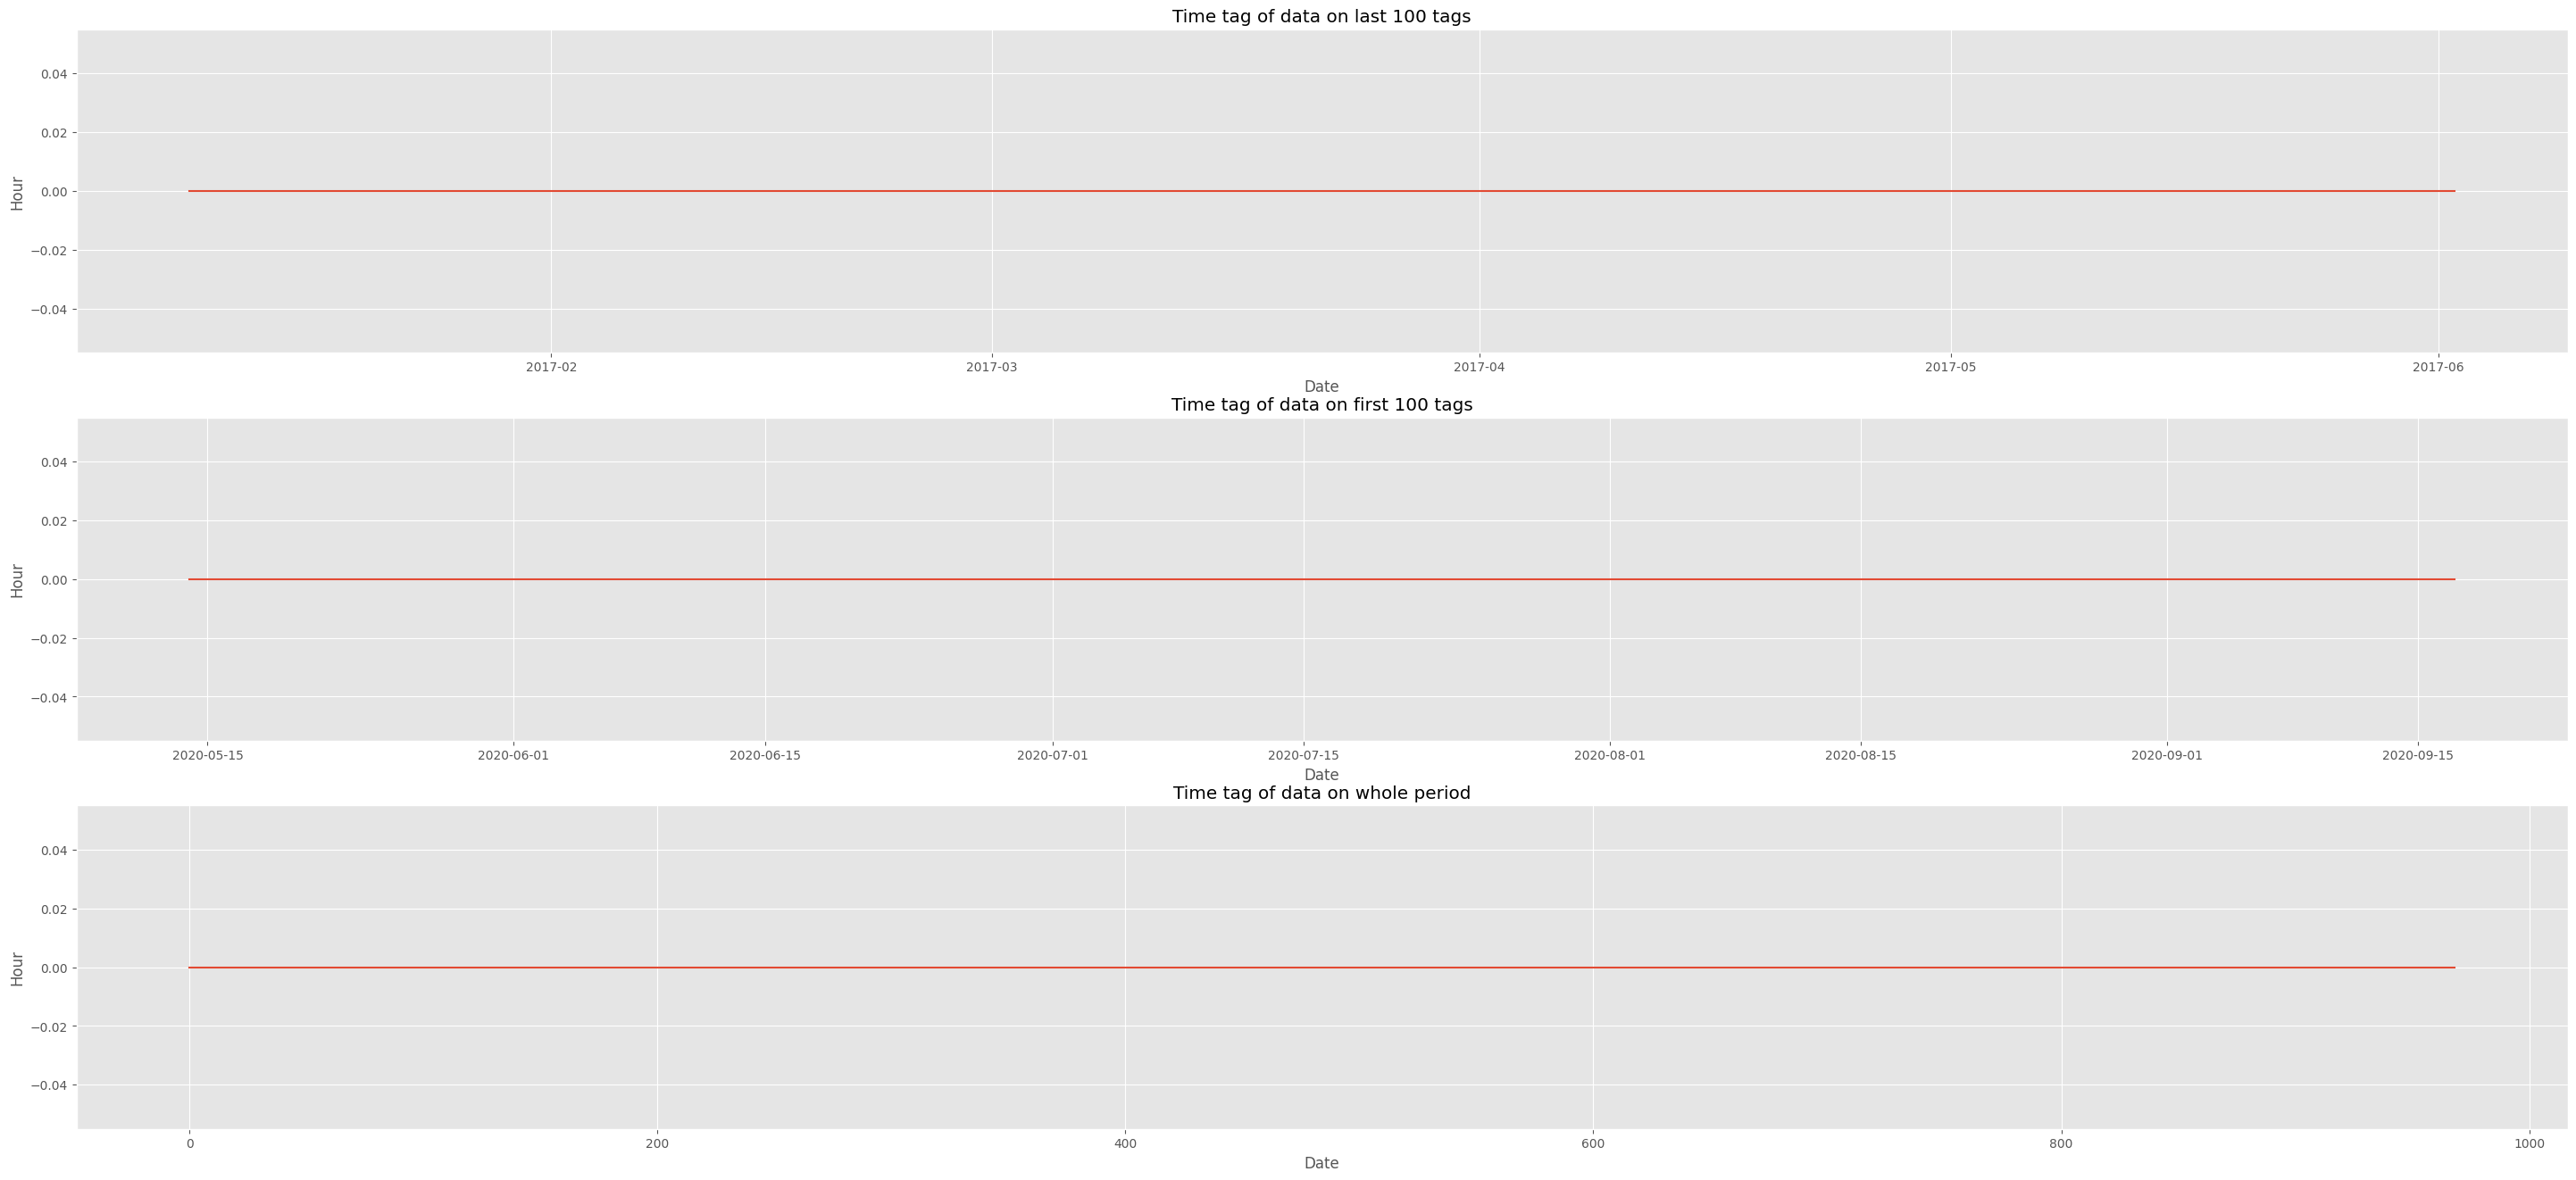

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (36, 16))
axs[0].plot(data_date.date[:100], data_date.date.dt.hour[:100])
axs[1].plot(data_date.date[-100:], data_date.date.dt.hour[-100:])
axs[2].plot( data_date.date.dt.hour)
for i in range(3):
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Hour')
    axs[i].set_title('Time tag of data on ' + (i == 2) * 'whole period' + (i == 1) * 'first 100 tags' + (i == 0) * 'last 100 tags' )
    ;

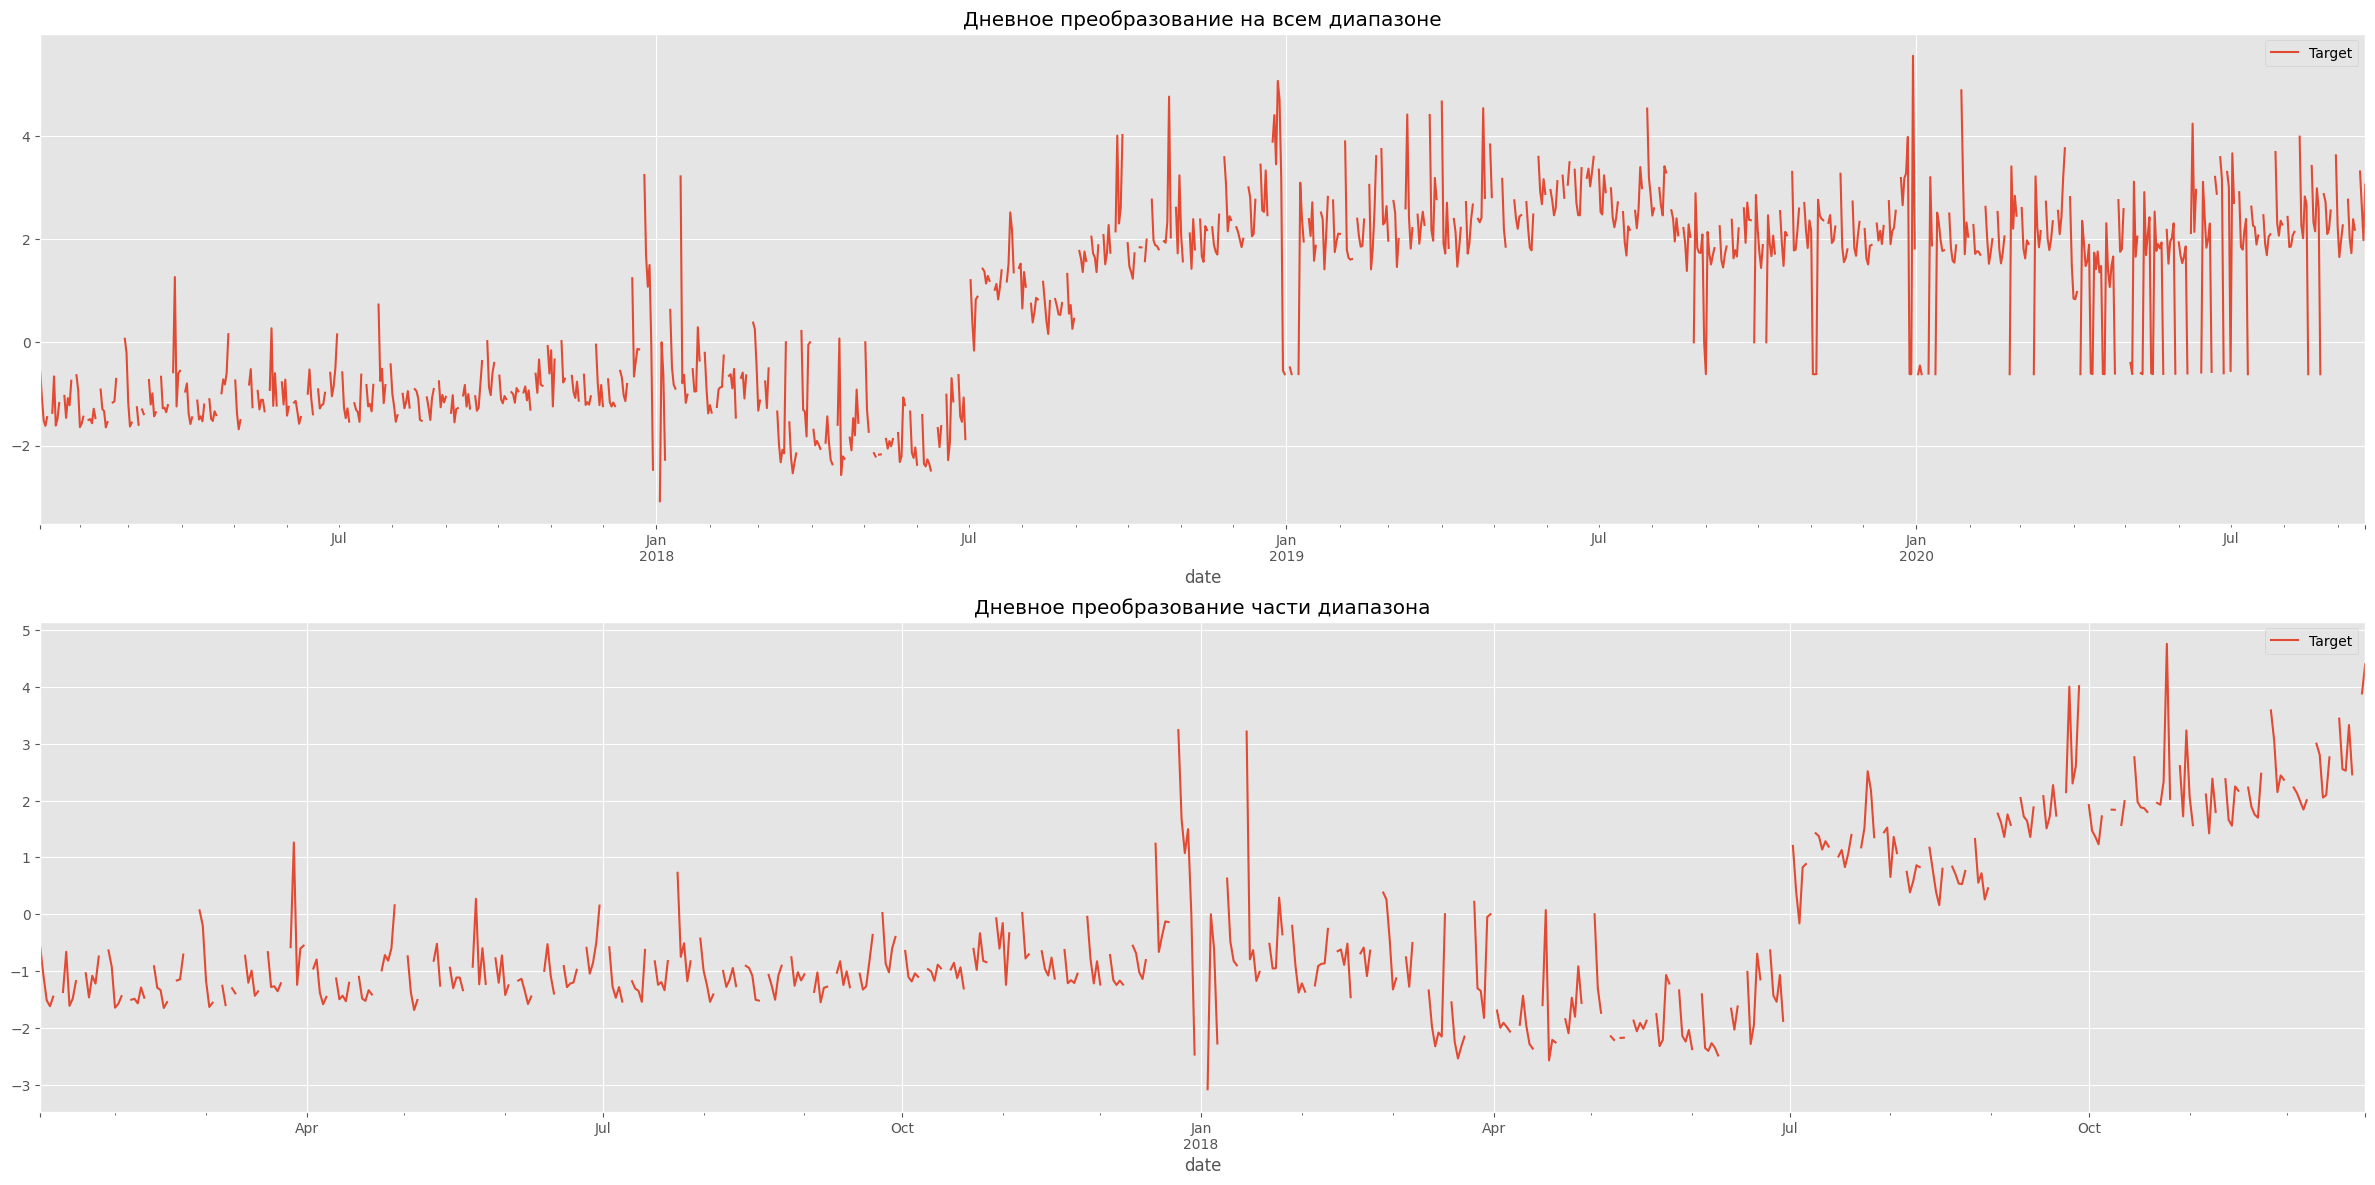

In [13]:
fig, axs = plt.subplots(2, 1, figsize = (30, 14))
data_date.resample('D', on = 'date').mean().plot(ax = axs[0])
axs[0].set_title('Дневное преобразование на всем диапазоне');
data_date[:500].resample('D', on = 'date').mean().plot(ax = axs[1])
axs[1].set_title('Дневное преобразование части диапазона');

Ряд выглядит уже более адекватно, но нужно заполнить выходные дни

In [14]:
data_resampled = data_date.resample('D', on = 'date').sum()
data_resampled.reset_index(inplace = True)

In [15]:
data_resampled_no_weekday = data_resampled[~data_resampled.date.dt.weekday.isin([5, 6])]

[]

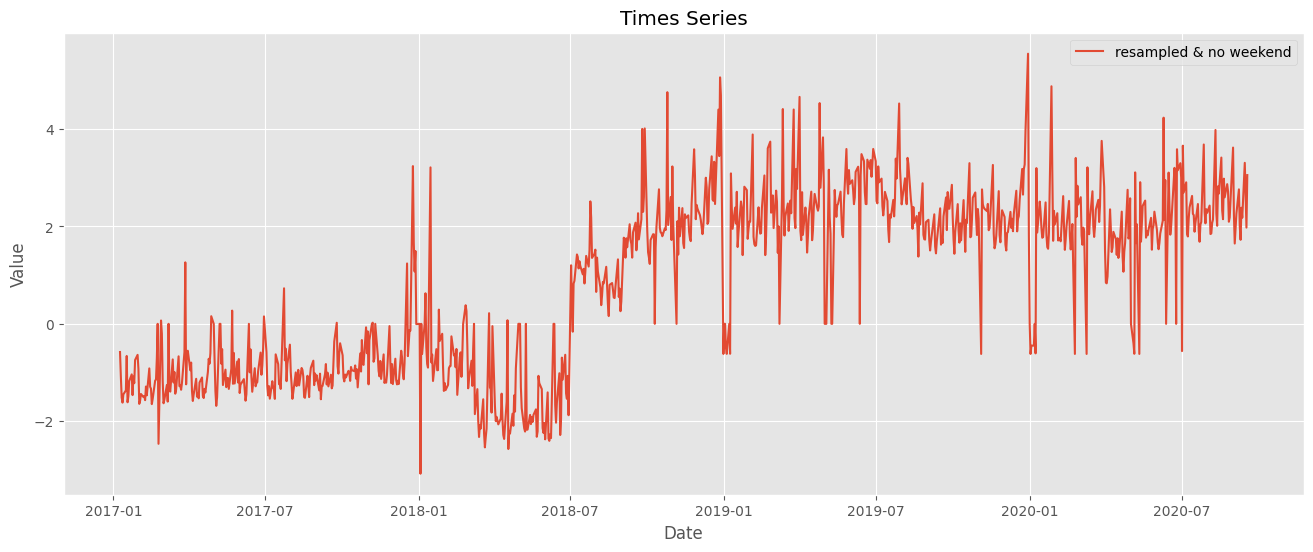

In [16]:
plt.figure(figsize = (16, 6))
plt.plot(data_resampled_no_weekday.date, data_resampled_no_weekday.Target, label = 'resampled & no weekend')
plt.title('Times Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.plot()

In [17]:
data_resampled_no_weekday_no_holidays = data_resampled_no_weekday[~((data_resampled_no_weekday['date'].dt.strftime('%m-%d').isin(['02-23', '03-08', '05-01', '05-08', '05-09', '06-11', '06-12', '01-01'])) & (data_resampled_no_weekday.Target == 0))]

[]

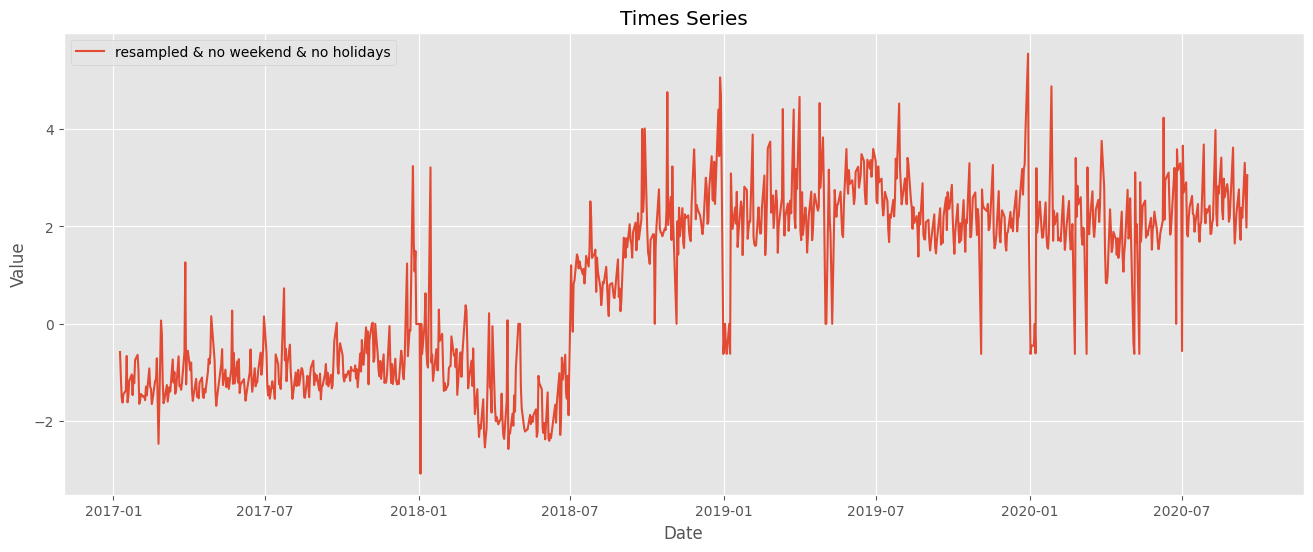

In [18]:
plt.figure(figsize = (16, 6))
plt.plot(data_resampled_no_weekday_no_holidays.date, data_resampled_no_weekday_no_holidays.Target, label = 'resampled & no weekend & no holidays')
plt.title('Times Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.plot()

Получилось на семплировать ряд, выполнив следуюдие преобразования:
- просуммировав значения внутри дня, т.к. это были переменные потока
- просемплировав значения по дням
- удалив выходные дни
- удалив праздники

In [19]:
data = data_resampled_no_weekday_no_holidays

## 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос. 

Хинт: если построить коррелограммы на приращениях ряда, а не на исходных величинах, то некоторые паттерны видны лучше.


In [20]:
data.index = data.date
data.drop('date', axis = 1, inplace = True)

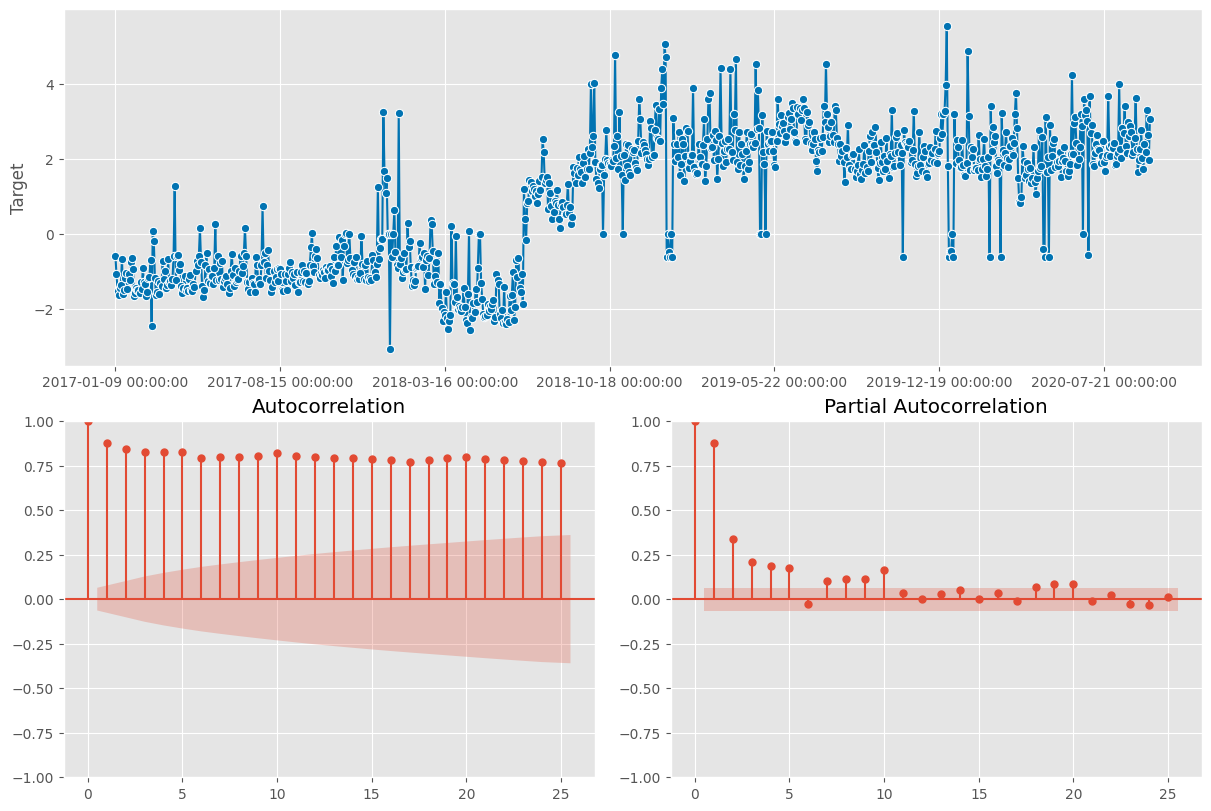

In [21]:
plot_correlations(data['Target'], lags = 25);

Ряд не стационарен, ACF плавно убывает, а PACF резко обрывается, значит это можно построить качественную AR модель если удалить тренд

In [298]:
data['increment'] = data['Target'].diff().fillna(0)

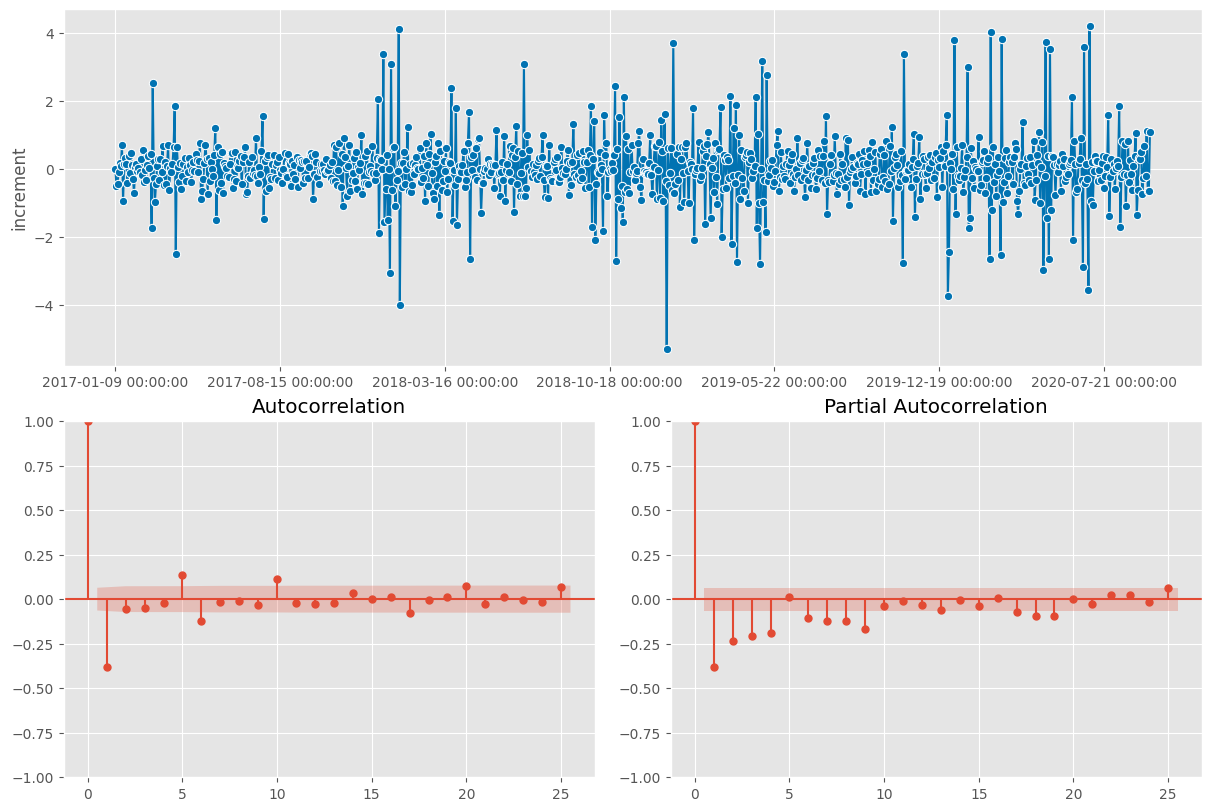

In [23]:
plot_correlations(data['increment'], lags = 25);

Ряд приращений уже стационарен, ACF резко обрывается, а PACF плавно убывает - значит можно подобрать качественную MA(1) модель

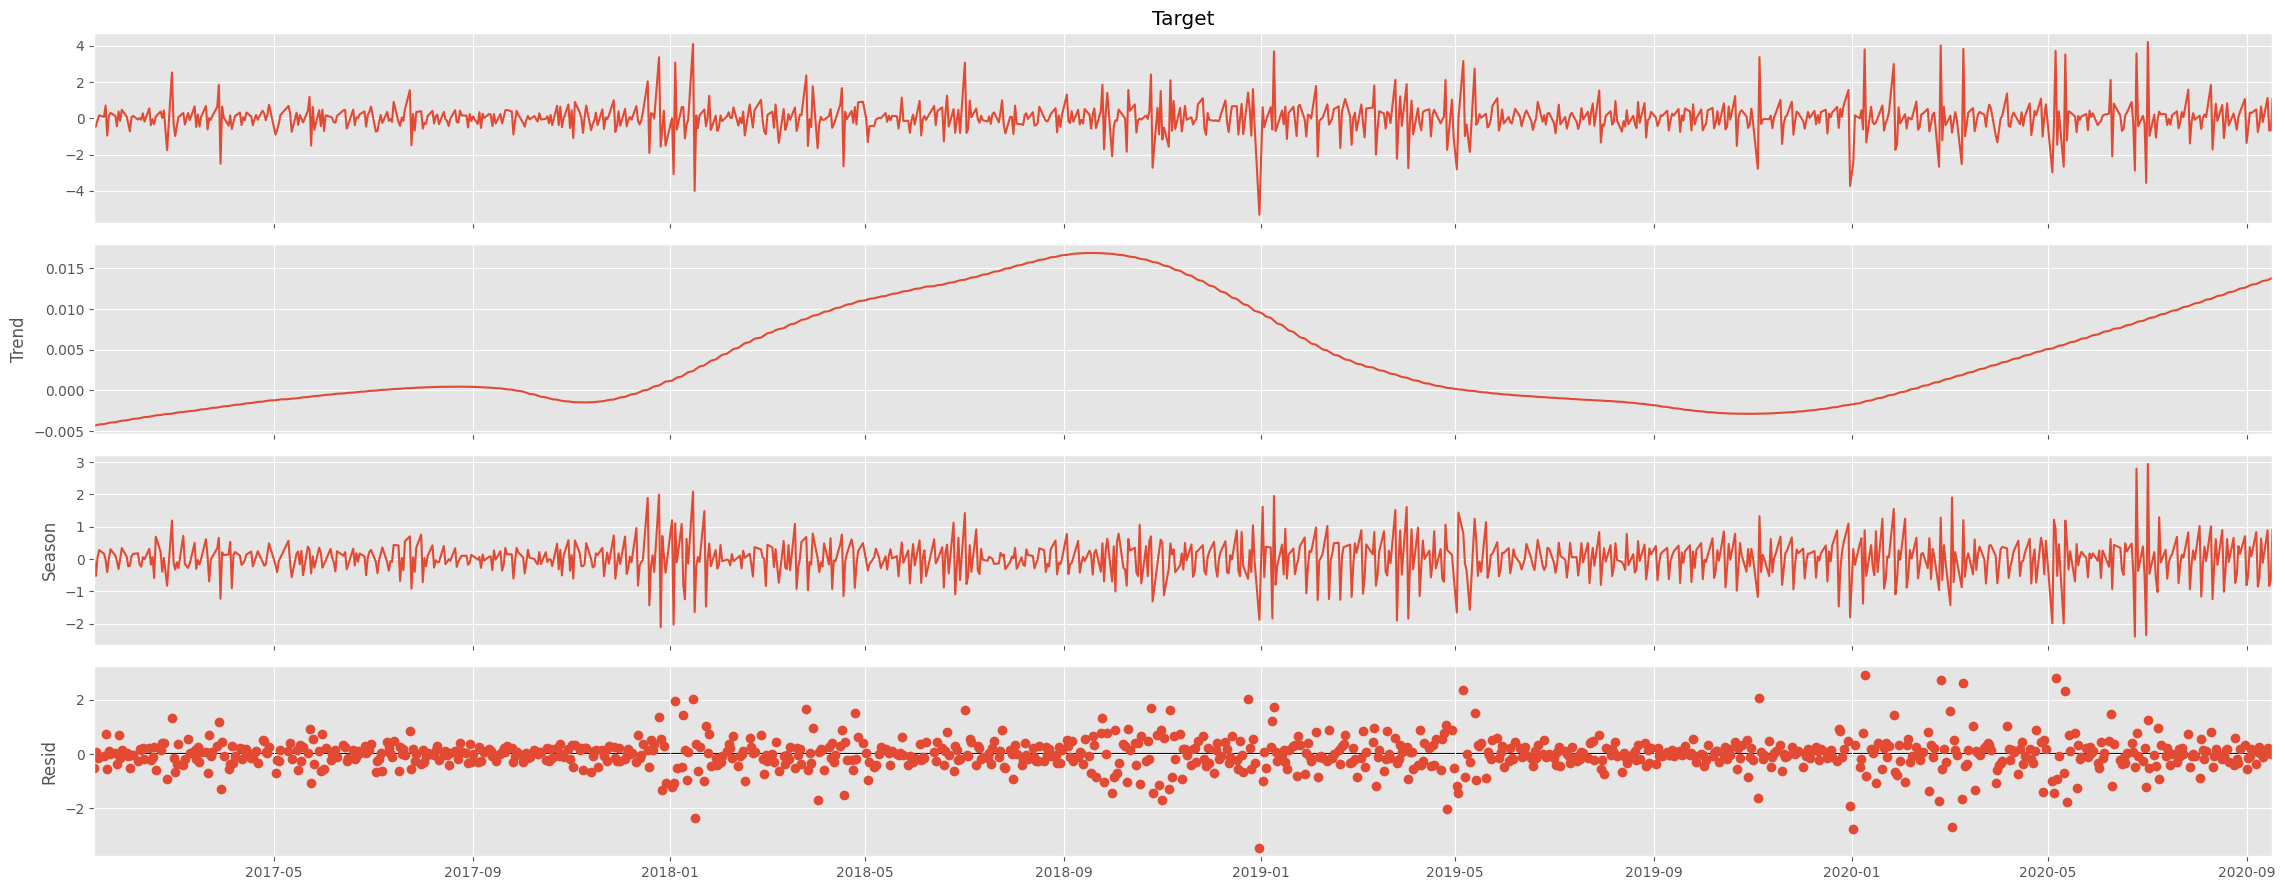

In [304]:
res =  STL(data['Target'].diff().dropna(), period = 5, seasonal=5, trend = 365).fit()
res.plot();

Как можно видеть, у самого таргета нет ярковыраженного тренда, отчетливо видно сезонность и цкличность.Видно, как после структурного сдвина изменилась дисперсия сезонности

## 3) Генерация признаков (3 балла)
Во временных рядах очень важно избегать утечек в данных (data leak). Их легко допуситть при неаккуратной генерации признаков. Например, если вы для прогноза $y_t$ будете исплользовать фичу разности $y_t - y_{t-1}$. Будьте осторожны и внимательны.

**Внимание!** При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе). 


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее. Фичи с утечками не засчитываются. Выбор каждой фичи необходимо обосновать. Фичи без обоснования не засчитываются.

1) (0.75 балла) Календарные фичи. Придумайте не менее пяти фичей из календаря. Выбор каждой обоснуйте.
2) (0.15 балла) Структурный сдвиг. В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.
3) (1 балл) Бонус! Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате весьма проблемно, придётся парсить, но это весьма сильная фича. Код парсинга (или описание того, как вы их выкачивали) необходимо приложить, иначе пункт не засчитывается.
4) (0.1 балла) Лаги таргета.  (до 5 разных). Выбор каждого лага обоснуйте.

5) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике. Например. YahooFinance</li>
<li>Спред ставок MosЗrime, все 7 показателей. Ставка MosPrime -- ставка кредитования в рублях на межбанковском рынке России. Спред -- разница между ставками кредита и депозита. У mosprime есть свой сайт.</li>
</ul>

6) Придумайте сами 2 фичи, которые считаете необходимыми (по 0.25 за каждую). Выбор каждой фичи обоснуйте.

__1) Календарные фичи__

Сначала нагенерируем базовые фичи, распределеяющие наблюдения по временным кластерам разного масштаба

In [26]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day_of_week'] = data.index.day_of_week

Также добавим фичи, которые показывают, что на прошлой неделе был хотя бы один праздничный день или наоборот на следующей будет хотя бы один праздничный день- возможно значение ликвидности в эти дни отличается от своего обычного значения

In [27]:
ru_holidays = holidays.Russia()

In [28]:
def holidays_on_prev_week(x):
    for days in range(1, 8):
        if x - datetime.timedelta(days = days) in ru_holidays:
            return True
    return False

In [29]:
def holidays_on_next_week(x):
    for days in range(1, 8):
        if x + datetime.timedelta(days = days) in ru_holidays:
            return True
    return False 

In [30]:
data['date'] = pd.to_datetime(data.index)
data['holidays_on_prev_week'] = data['date'].apply(lambda x: holidays_on_prev_week(x))
data['holidays_on_next_week'] = data['date'].apply(lambda x: holidays_on_next_week(x))

__2) Структурный сдвиг__

Добавим два свдига: один сдвиг был - сдвиг параметра Target, а второй - изменение принципа записи данных, вмето 8 раз в день, начали делать один раз в день

In [31]:
data['target_shift_dummy'] = np.where(data.index < '2018-07-01', 0, 1)

In [32]:
data['structure_shift_dummy'] = np.where(data.index < '2018-09-01', 0, 1)

__3) Бухгалтерские дни__

In [33]:


month_names = {
    'january': '01',
    'february': '02',
    'march': '03',
    'april': '04',
    'may': '05',
    'june': '06',
    'july': '07',
    'august': '08',
    'september': '09',
    'october': '10',
    'november': '11',
    'december': '12'
}

nalog_days = []

# 18 год
tree = ET.parse('data-20171219-structure-20140228.xml')
root = tree.getroot()
for year in root.findall('.//year'):
    year_index = year.get('index')
    for month in year.findall('.//month'):
        month_name = month.get('name')
        month_number = month_names.get(month_name.lower()) 
        for day in month.findall('.//day[@type="event"]'):
            day_num = day.get('num')
            nalog_days.append(f'{year_index}-{month_number}-{day_num}')

# 19 год
tree = ET.parse('data-20190118-structure-20140228.xml')
root = tree.getroot()
for year in root.findall('.//year'):
    year_index = year.get('index')
    for month in year.findall('.//month'):
        month_name = month.get('name')
        month_number = month_names.get(month_name.lower()) 
        for day in month.findall('.//day[@type="event"]'):
            day_num = day.get('num')
            nalog_days.append(f'{year_index}-{month_number}-{day_num}')


#20 год
tree = ET.parse('data-20190118-structure-20140228.xml')
root = tree.getroot()
for year in root.findall('.//year'):
    year_index = year.get('index')
    for month in year.findall('.//month'):
        month_name = month.get('name')
        month_number = month_names.get(month_name.lower()) 
        for day in month.findall('.//day[@type="event"]'):
            day_num = day.get('num')
            nalog_days.append(f'{year_index}-{month_number}-{day_num}')

.xml файлы взял из https://www.nalog.gov.ru/opendata/7707329152-kalendar/

Там не было почему-то данных за 2017, поэтому я ручками добавил, взяв отсюда - https://cyberleninka.ru/article/n/federalnyy-nalogovyy-kalendar-na-iyul-sentyabr-2017-goda-1/viewer

In [34]:
for date in ['2017-07-03', '2017-07-14', '2017-07-17', '2017-07-18', '2017-07-20', '2017-07-25', '2017-07-28', '2017-07-31', '2017-08-14', '2017-08-15', '2017-08-18', '2017-08-21', '2017-08-25', '2017-08-28', '2017-08-31', '2017-09-14', '2017-09-15', '2017-09-18', '2017-09-20', '2017-09-25', '2017-09-28']:
    nalog_days.append(date)
nalog_days

['2018-01-9',
 '2018-01-12',
 '2018-01-15',
 '2018-01-18',
 '2018-01-22',
 '2018-01-25',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-1',
 '2018-02-14',
 '2018-02-15',
 '2018-02-19',
 '2018-02-20',
 '2018-02-26',
 '2018-02-28',
 '2018-03-1',
 '2018-03-7',
 '2018-03-15',
 '2018-03-16',
 '2018-03-19',
 '2018-03-20',
 '2018-03-26',
 '2018-03-28',
 '2018-03-30',
 '2018-04-2',
 '2018-04-13',
 '2018-04-16',
 '2018-04-18',
 '2018-04-20',
 '2018-04-25',
 '2018-04-28',
 '2018-05-3',
 '2018-05-15',
 '2018-05-17',
 '2018-05-18',
 '2018-05-21',
 '2018-05-25',
 '2018-05-28',
 '2018-05-31',
 '2018-06-15',
 '2018-06-18',
 '2018-06-20',
 '2018-06-25',
 '2018-06-28',
 '2018-07-2',
 '2018-07-13',
 '2018-07-16',
 '2018-07-18',
 '2018-07-20',
 '2018-07-25',
 '2018-07-30',
 '2018-07-31',
 '2018-08-14',
 '2018-08-15',
 '2018-08-20',
 '2018-08-27',
 '2018-08-28',
 '2018-08-31',
 '2018-09-14',
 '2018-09-17',
 '2018-09-18',
 '2018-09-20',
 '2018-09-25',
 '2018-09-28',
 '2018-10-1',
 '2018-10-9',
 '20

In [35]:
data["is_nalog_day"] = np.nan
data["is_nalog_day"] = np.where(data.index.isin(nalog_days), 1, 0)

__4) Лаги таргета__

PACF обрывается после lag = 5, поэтому будем предсказывать на основе 5 предыдущих наблюдений

In [36]:
lags = [1, 2, 3, 4, 5]
for lag in lags:
    data[f'target lag {lag}'] = data['Target'].shift(lag).fillna(0)

__5) Экзогенные фичи__

_Ключевая ставка_

In [37]:

url = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2017&UniDbQuery.To=21.09.2020'

response = requests.get(url)
html_content = response.text

soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', class_='data')
rate_dict = {'date':[], 'rate':[]}

rows = table.find_all('tr')
for row in rows:
    cells = row.find_all('td')
    if cells:
        date = cells[0].text.strip()
        rate = cells[1].text.strip()
        rate_dict['date'].append(date)
        rate_dict['rate'].append(rate)
            

rate_df = pd.DataFrame(rate_dict)[1:]
rate_df['date'] = pd.to_datetime(rate_df['date'], format='%d.%m.%Y')
rate_df['date'] = rate_df['date'].dt.strftime('%Y-%m-%d')
rate_df['rate'] = rate_df['rate'].str.replace(',', '.').astype(float)

rate_df.index = rate_df.date
rate_df.drop('date', inplace = True, axis = 1)

In [38]:
data.index = pd.to_datetime(data.index)
rate_df.index = pd.to_datetime(rate_df.index)
data = pd.merge(data, rate_df, how='left', left_index=True, right_index=True)

In [39]:
data['rate'] = data['rate'].fillna(method='ffill')

_Обменный курс доллара_

In [40]:
dollar_df = pd.read_excel('RC_F09_01_2017_T17_09_2020.xlsx')

In [41]:
dollar_df.index = dollar_df.data
dollar_df.index = pd.to_datetime(dollar_df.index)
data = pd.merge(data, dollar_df['curs'], how='left', left_index=True, right_index=True)

In [42]:
data['curs'][0] = 59.8961

In [43]:
data['curs'] = data['curs'].fillna(method='ffill')

_Спред ставок Mosprime_

In [44]:
url = 'https://www.cbr.ru/hd_base/mosprime-spread/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=17.09.2020'
response = requests.get(url)
html_content = response.text
spread_data = []
soup = BeautifulSoup(html_content, 'html.parser')
rows = soup.find_all('tr')[3:]
for row in rows:
        cells = row.find_all('td')
        if cells:
            date = cells[0].text.strip()
            rate = cells[1].text.strip()
            spread_data.append({'date': date, 'rate': rate})


spread_df = pd.DataFrame(spread_data)[1:]
spread_df['date'] = pd.to_datetime(spread_df['date'], format='%d.%m.%Y')
spread_df['date'] = spread_df['date'].dt.strftime('%Y-%m-%d')
spread_df['rate'] = spread_df['rate'].str.replace(',', '.').astype(float)

spread_df.index = spread_df.date
spread_df.drop('date', inplace = True, axis = 1)

In [45]:
spread_df.index = pd.to_datetime(spread_df.index)

In [46]:
spread_df.index = pd.to_datetime(spread_df.index)
data = pd.merge(data, spread_df['rate'], how='left', left_index=True, right_index=True)

In [47]:
data.rename(columns={'rate_x':'rate', 'rate_y':'spread'}, inplace = True)

In [48]:
data['spread'] = data['spread'].fillna(method='ffill')

__6) Cвои фичи__

Добавим агрегированные статистики на приращениях значений по различного размера окнам и отберем несколько наиболее скоррелированных с таргетом 

In [49]:
def add_agg_statistics(
    data : pd.DataFrame,
    agg_func : str, 
    window : int
):
    if agg_func == 'mean':
        data[f'{agg_func} of inc on {window} days'] = data['increment'].rolling(window = window).mean().shift(1).fillna(0)
    if agg_func == 'sum':
        data[f'{agg_func} of inc on {window} days'] = data['increment'].rolling(window = window).sum().shift(1).fillna(0)
    if agg_func == 'std':
        data[f'{agg_func} of inc on {window} days'] = data['increment'].rolling(window = window).std().shift(1).fillna(0)

In [50]:
print('Correlations with target:')
for window in [5, 10, 25, 50, 100]:
    for agg_func in ['mean', 'sum', 'std']:
        add_agg_statistics(data, agg_func, window)
        print(f'{agg_func} of inc on {window} days - {np.corrcoef(data['Target'], data[f"{agg_func} of inc on {window} days"])[0, 1]}')


Correlations with target:
mean of inc on 5 days - 0.1301802210328389
sum of inc on 5 days - 0.130180221032839
std of inc on 5 days - 0.16956407107209623
mean of inc on 10 days - 0.10648034155852064
sum of inc on 10 days - 0.10648034155852065
std of inc on 10 days - 0.2230719291792181
mean of inc on 25 days - 0.16490247153044743
sum of inc on 25 days - 0.16490247153044735
std of inc on 25 days - 0.3487592537037597
mean of inc on 50 days - 0.19604522216275344
sum of inc on 50 days - 0.19604522216275355
std of inc on 50 days - 0.4413504021232757
mean of inc on 100 days - 0.27385334721389265
sum of inc on 100 days - 0.27385334721389265
std of inc on 100 days - 0.5032779312286595


Наиболее коррелирующими оказались стандартное отклонение приращений за последние 25, 50 и 100 наблюдений, а также сумма и среднее приращений за последние 100 дней, их и добавим, а остальные уберем

In [51]:
del data['mean of inc on 5 days']
del data['sum of inc on 5 days']
del data['std of inc on 5 days']
del data['mean of inc on 10 days']
del data['sum of inc on 10 days']
del data['std of inc on 10 days']
del data['mean of inc on 25 days']
del data['sum of inc on 25 days']
del data['mean of inc on 50 days']
del data['sum of inc on 50 days']

In [52]:
data.shape

(943, 24)

Чтобы не было лика

In [53]:
data['curs'] = data['curs'].shift(1).fillna(0)
data['rate'] = data['rate'].shift(1).fillna(0)
data['spread'] = data['spread'].shift(1).fillna(0)

In [54]:
data.drop('increment', axis = 1, inplace = True)

## 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

#### 4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [55]:
data['target_shift_dummy'] = data['target_shift_dummy'].astype(bool)
data['structure_shift_dummy'] = data['structure_shift_dummy'].astype(bool)
data['is_nalog_day'] = data['is_nalog_day'].astype(bool)

In [55]:
train, test = data[:int(data.shape[0] * 0.8)], data[int(data.shape[0] * 0.8):]

In [56]:
x_train, y_train, x_test, y_test = train.drop('Target', axis = 1), train['Target'], test.drop('Target', axis = 1), test['Target']

In [57]:
numeric_features = ['target lag 1', 'target lag 2', 'target lag 3',
       'target lag 4', 'target lag 5', 'curs', 'rate', 'spread']
categorical_features = ['target_shift_dummy', 'structure_shift_dummy', 'is_nalog_day', 'holidays_on_prev_week',	'holidays_on_next_week']
other_features = ['year', 'month', 'day_of_week']

In [58]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
preprocessor.fit(x_train)
feature_names_out = preprocessor.get_feature_names_out()
x_train_transformed = pd.DataFrame(preprocessor.transform(x_train), columns=feature_names_out)
x_test_transformed = pd.DataFrame(preprocessor.transform(x_test), columns=feature_names_out)

In [59]:
x_train_transformed

num__target lag 1 num__target lag 2 num__target lag 3 num__target lag 4  \
0           -0.298881         -0.296939         -0.295284         -0.293798   
1           -0.621964         -0.296939         -0.295284         -0.293798   
2           -0.902583         -0.620472         -0.295284         -0.293798   
3           -1.144364         -0.901481         -0.619071         -0.293798   
4           -1.201903         -1.143599           -0.9003         -0.617757   
..                ...               ...               ...               ...   
749          0.760924          1.230561          0.965041          0.770368   
750          0.902917          0.764339          1.233415            0.9672   
751          0.937135          0.906529          0.766827          1.235718   
752          1.121852          0.940796          0.909129           0.76888   
753          1.475796          1.125769          0.943422          0.911258   

    num__target lag 5 num__curs num__rate num__spread  \
0           -0.292344 -14.20399 -8.064258     -16.664   
1           -0.292344 -0.454843  2.090983   -0.792856   
2           -0.292344 -0.454843  2.090983   -0.792856   
3           -0.292344 -0.441713  2.090983   -0.792856   
4           -0.292344 -0.393943  2.090983   -0.792856   
..                ...       ...       ...         ...   
749          0.915814  0.204539 -1.717232    1.191037   
750          0.772348  0.150366 -1.717232    1.191037   
751          0.969278  0.161958 -1.717232    1.191037   
752          1.237929  0.149379 -1.717232    1.191037   
753           0.77086  0.149379 -1.717232    1.191037   

    cat__target_shift_dummy_False cat__target_shift_dummy_True  ...  \
0                             1.0                          0.0  ...   
1                             1.0                          0.0  ...   
2                             1.0                          0.0  ...   
3                             1.0                          0.0  ...   
4                             1.0                          0.0  ...   
..                            ...                          ...  ...   
749                           0.0                          1.0  ...   
750                           0.0                          1.0  ...   
751                           0.0                          1.0  ...   
752                           0.0                          1.0  ...   
753                           0.0                          1.0  ...   

    cat__holidays_on_next_week_True remainder__year remainder__month  \
0                               0.0            2017                1   
1                               0.0            2017                1   
2                               0.0            2017                1   
3                               0.0            2017                1   
4                               0.0            2017                1   
..                              ...             ...              ...   
749                             0.0            2019               12   
750                             0.0            2019               12   
751                             0.0            2019               12   
752                             0.0            2019               12   
753                             0.0            2019               12   

    remainder__day_of_week remainder__date remainder__std of inc on 25 days  \
0                        0      2017-01-09                              0.0   
1                        1      2017-01-10                              0.0   
2                        2      2017-01-11                              0.0   
3                        3      2017-01-12                              0.0   
4                        4      2017-01-13                              0.0   
..                     ...             ...                              ...   
749                      2      2019-12-18                         0.553436   
750                 

In [60]:
x_test_transformed

num__target lag 1 num__target lag 2 num__target lag 3 num__target lag 4  \
0            1.182192          1.480205          1.128541           0.94557   
1            1.475203          1.186193          1.483255          1.130788   
2            1.527173          1.479611          1.189013          1.485691   
3            1.920293          1.531654           1.48266          1.191291   
4            2.796975          1.925321          1.534744          1.485096   
..                ...               ...               ...               ...   
184          1.031818          0.667371          0.827571          1.251572   
185          0.917343           1.03561          0.669783          0.829657   
186          1.546335          0.920976          1.038311          0.671784   
187           1.17632          1.550842          0.923587          1.040509   
188          0.804389          1.180313          1.553948          0.925724   

    num__target lag 5 num__curs num__rate num__spread  \
0            0.913308  0.085472 -1.717232    1.191037   
1            0.947637  0.066511 -1.717232    1.191037   
2            1.132946 -0.036993 -1.717232    1.191037   
3            1.488026  -0.02524 -1.717232    1.191037   
4             1.19348  -0.02524 -1.717232    1.191037   
..                ...       ...       ...         ...   
184          0.975591  3.258174 -3.748281     0.52974   
185          1.253791  3.133321 -3.748281     0.52974   
186          0.831667  3.133321 -3.748281     0.52974   
187          0.673716  2.946789 -3.748281     0.52974   
188          1.042623  3.055504 -3.748281     0.52974   

    cat__target_shift_dummy_False cat__target_shift_dummy_True  ...  \
0                             0.0                          1.0  ...   
1                             0.0                          1.0  ...   
2                             0.0                          1.0  ...   
3                             0.0                          1.0  ...   
4                             0.0                          1.0  ...   
..                            ...                          ...  ...   
184                           0.0                          1.0  ...   
185                           0.0                          1.0  ...   
186                           0.0                          1.0  ...   
187                           0.0                          1.0  ...   
188                           0.0                          1.0  ...   

    cat__holidays_on_next_week_True remainder__year remainder__month  \
0                               1.0            2019               12   
1                               1.0            2019               12   
2                               1.0            2019               12   
3                               1.0            2019               12   
4                               1.0            2019               12   
..                              ...             ...              ...   
184                             0.0            2020                9   
185                             0.0            2020                9   
186                             0.0            2020                9   
187                             0.0            2020                9   
188                             0.0            2020                9   

    remainder__day_of_week remainder__date remainder__std of inc on 25 days  \
0                        2      2019-12-25                         0.446802   
1                        3      2019-12-26                         0.451649   
2                        4      2019-12-27                         0.451676   
3                        0      2019-12-30                         0.469151   
4                        1      2019-12-31                          0.53091   
..                     ...             ...                              ...   
184                      4      2020-09-11                         0.795735   
185                 

#### 4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте WAPE. 

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

In [94]:
def wape(actual, forecast):
    return np.sum(np.abs(actual-forecast))/np.sum(np.abs(actual)) 
score = make_scorer(wape, greater_is_better=False)

In [70]:
сb = CatBoostRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=52)
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5, 6],

}
grid_search = GridSearchCV(estimator=сb, param_grid=param_grid, cv=kf, scoring=score)
grid_search.fit(x_train_transformed, y_train)
clear_output()

In [71]:
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

In [72]:
clf_grid = CatBoostRegressor(**grid_search.best_params_)
clf_grid.fit(x_train_transformed,y_train)
clear_output()
y_pred = clf_grid.predict(x_test_transformed)
print('WAPE:', wape(y_test, y_pred))

WAPE: 0.27007210176333823


#### 4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна. Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [74]:
y_pred_naive = y_test.shift(1).fillna(0)
print('WAPE:', wape(y_test, y_pred_naive))

WAPE: 0.35051365905541454


#### 4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

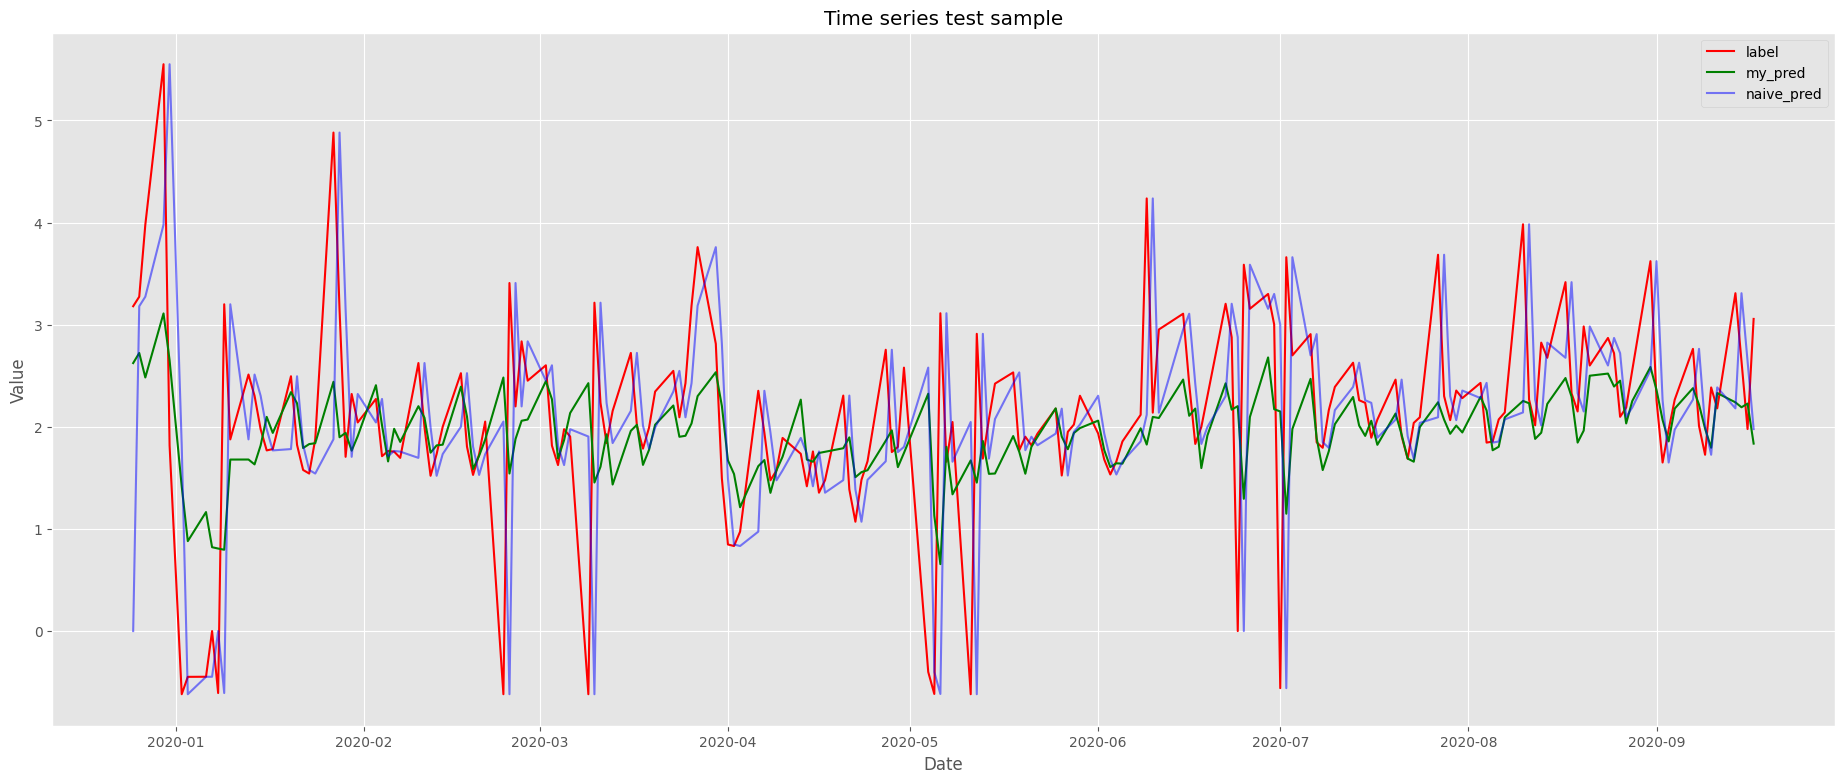

In [80]:
plt.plot(y_test.index, y_test.values, label = 'label', color = 'red')
plt.plot(y_test.index, y_pred, label = 'my_pred', color = 'green')
plt.plot(y_test.index, y_pred_naive, label = 'naive_pred', color = 'blue', alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

In [85]:
y_test_bool = y_test >= 0
y_pred_bool = y_pred >= 0
y_pred_naive_bool = y_pred_naive >= 0

In [89]:
from sklearn.metrics import accuracy_score

In [93]:
print(f'Accuracy for my model:', accuracy_score(y_test_bool, y_pred_bool))
print(f'Accuracy for naive model:', accuracy_score(y_test_bool, y_pred_naive_bool))

Accuracy for my model: 0.9470899470899471
Accuracy for naive model: 0.9259259259259259


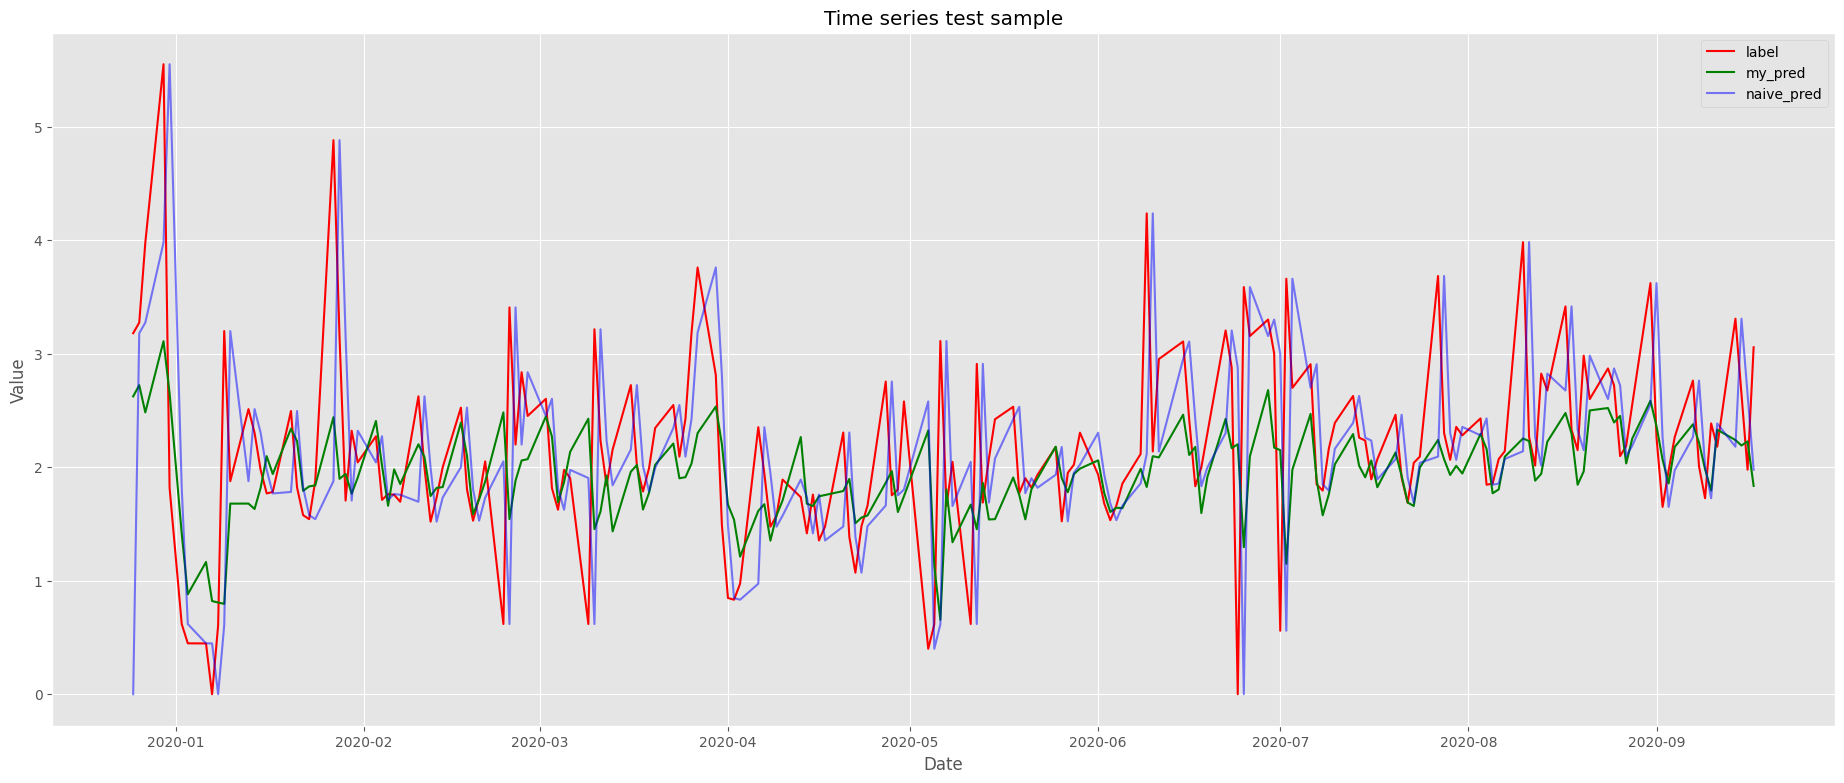

In [94]:
plt.plot(y_test.index, np.abs(y_test.values), label = 'label', color = 'red')
plt.plot(y_test.index, np.abs(y_pred), label = 'my_pred', color = 'green')
plt.plot(y_test.index, np.abs(y_pred_naive), label = 'naive_pred', color = 'blue', alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

Как можно видеть, моя модель предсказывает в целом неплохо, она угадывает знак движения, но не может определить качественно абсолютное значение показателя

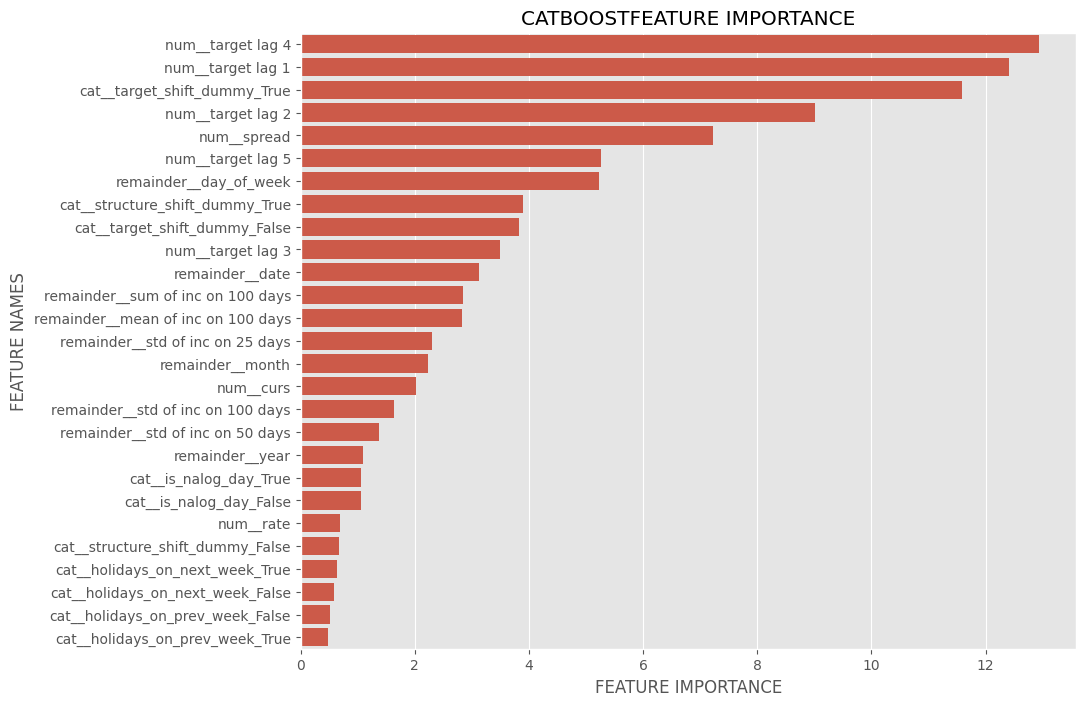

In [73]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf_grid.get_feature_importance(),x_train_transformed.columns,'CATBOOST')

Все фичи оказали влияние, но лучше всего себя показали лаги, дамми переменные сдвигов и спред

## 5) Многошаговое прогнозирование


Описание всех необходимых стратегий есть в [Конспекте](https://github.com/Pyatachokk/hse_ts_course/blob/master/2024-spring/seminars/sem_02_tables.pdf)

#### 5.1) Повтор препроцессинга (0 баллов)

Вернёмся к полному датасету. Повторите разбиение на трейн и тест. Возьмём в качестве теста последние 50 наблюдений. Соответственно, горизонт прогнозирования будет равен 50. Для упрощения задачи уберём все экзогенные переменные из датасета, которые нужно прогнозировать. Оставим только лаги таргета, календарные фичи и придуманные вами фичи если их не надо прогнозировать. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

Уберем все экзогенные фичи, а также агрегированные фичи, потому что они будут смещены в сторону смещения моих прогнозов

In [260]:
train, test = data[:-50], data[-50:]

In [261]:
train.drop(['curs', 'rate', 'spread', 'std of inc on 25 days',
       'std of inc on 50 days', 'mean of inc on 100 days',
       'sum of inc on 100 days', 'std of inc on 100 days'], axis = 1, inplace = True)
test.drop(['curs', 'rate', 'spread', 'std of inc on 25 days',
       'std of inc on 50 days', 'mean of inc on 100 days',
       'sum of inc on 100 days', 'std of inc on 100 days'], axis = 1, inplace = True)

In [262]:
x_train, y_train, x_test, y_test = train.drop('Target', axis = 1), train['Target'], test.drop('Target', axis = 1), test['Target']

In [263]:
numeric_features = ['target lag 1', 'target lag 2', 'target lag 3',
       'target lag 4', 'target lag 5']
categorical_features = ['target_shift_dummy', 'structure_shift_dummy', 'is_nalog_day', 'holidays_on_prev_week',	'holidays_on_next_week']
other_features = ['year', 'month', 'day_of_week']

In [264]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
preprocessor.fit(x_train)
feature_names_out = preprocessor.get_feature_names_out()
x_train_transformed = pd.DataFrame(preprocessor.transform(x_train), columns=feature_names_out)
x_test_transformed = pd.DataFrame(preprocessor.transform(x_test), columns=feature_names_out)

#### 5.2) Рекурсивная стратегия (2 балла)

Внимание! Внимание! Запрещается пользоваться готовыми функциями. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [265]:
сb = CatBoostRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=52)
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5, 6],

}
grid_search = GridSearchCV(estimator=сb, param_grid=param_grid, cv=kf, scoring=score)
grid_search.fit(x_train_transformed, y_train)
clear_output()

In [266]:
clf_grid = CatBoostRegressor(**grid_search.best_params_)
clf_grid.fit(x_train_transformed,y_train)
clear_output()

Я строю модель вида 
$$
\hat{y}_{t+h+1} = \gamma \hat{x}_{t+h} 
$$
$\gamma \hat{x}_{t+h} $ включает в себя 5 лагов, что является оценками таргета

Оценки параметров считаются легко, так как это либо лаги, либо календарные переменные, либо индикаторы сдвигов или бухгалтерских дней

In [267]:
for _ in range(50):
    Target_ = clf_grid.predict(pd.DataFrame(preprocessor.transform(train), columns=feature_names_out)[-1:]).item()
    index_ = train.iloc[-1]['date'] + datetime.timedelta(days = 1)
    year_ = index_.year
    month_ = index_.month
    day_of_week_ = index_.day_of_week
    date_ = index_
    holidays_on_prev_week_ = holidays_on_prev_week(index_)
    holidays_on_next_week_ = holidays_on_next_week(index_)
    target_shift_dummy_ = np.where(index_ < pd.to_datetime('2018-07-01'), 0, 1)
    structure_shift_dummy_ = np.where(index_< pd.to_datetime('2018-09-01'), 0, 1)
    is_nalog_day_ = np.where(index_ in nalog_days, 1, 0)
    target_lag_1_ = train.iloc[-1].Target
    target_lag_2_ = train.iloc[-2].Target
    target_lag_3_ = train.iloc[-3].Target
    target_lag_4_ = train.iloc[-4].Target
    target_lag_5_ = train.iloc[-5].Target
    row = {
        'year' : year_,
        'month' : month_,
        'day_of_week' : day_of_week_,
        'date' : date_,
        'holidays_on_prev_week' : holidays_on_prev_week_,
        'holidays_on_prev_week' : holidays_on_prev_week_,
        'target_shift_dummy' : target_shift_dummy_,
        'structure_shift_dummy' : structure_shift_dummy_,
        'is_nalog_day' : is_nalog_day_,
        'target lag 1' : target_lag_1_,
        'target lag 2' : target_lag_2_,
        'target lag 3' : target_lag_3_,
        'target lag 4' : target_lag_4_,
        'target lag 5' : target_lag_5_,
        'Target' : Target_
    }
    row_df = pd.Series(row)
    train = pd.concat([train,  pd.DataFrame(row_df).T])
    train['holidays_on_prev_week'] = train['holidays_on_prev_week'].astype('bool')
    train['holidays_on_next_week'] = train['holidays_on_next_week'].astype('bool')
    train['target_shift_dummy'] = train['target_shift_dummy'].astype('bool')
    train['structure_shift_dummy'] = train['structure_shift_dummy'].astype('bool')
    train['is_nalog_day'] = train['is_nalog_day'].astype('bool')

y_pred = train.Target[-50:]
y_pred.index = y_test.index

print('WAPE:', wape(y_test, y_pred))

WAPE: 0.20487647274341678


Сравним с одношаговой

In [268]:
clf_grid = CatBoostRegressor(**grid_search.best_params_)
clf_grid.fit(x_train_transformed,y_train)
clear_output()
y_pred_one_step = clf_grid.predict(x_test_transformed)
print('WAPE:', wape(y_test, y_pred_one_step))

WAPE: 0.13138563144860266


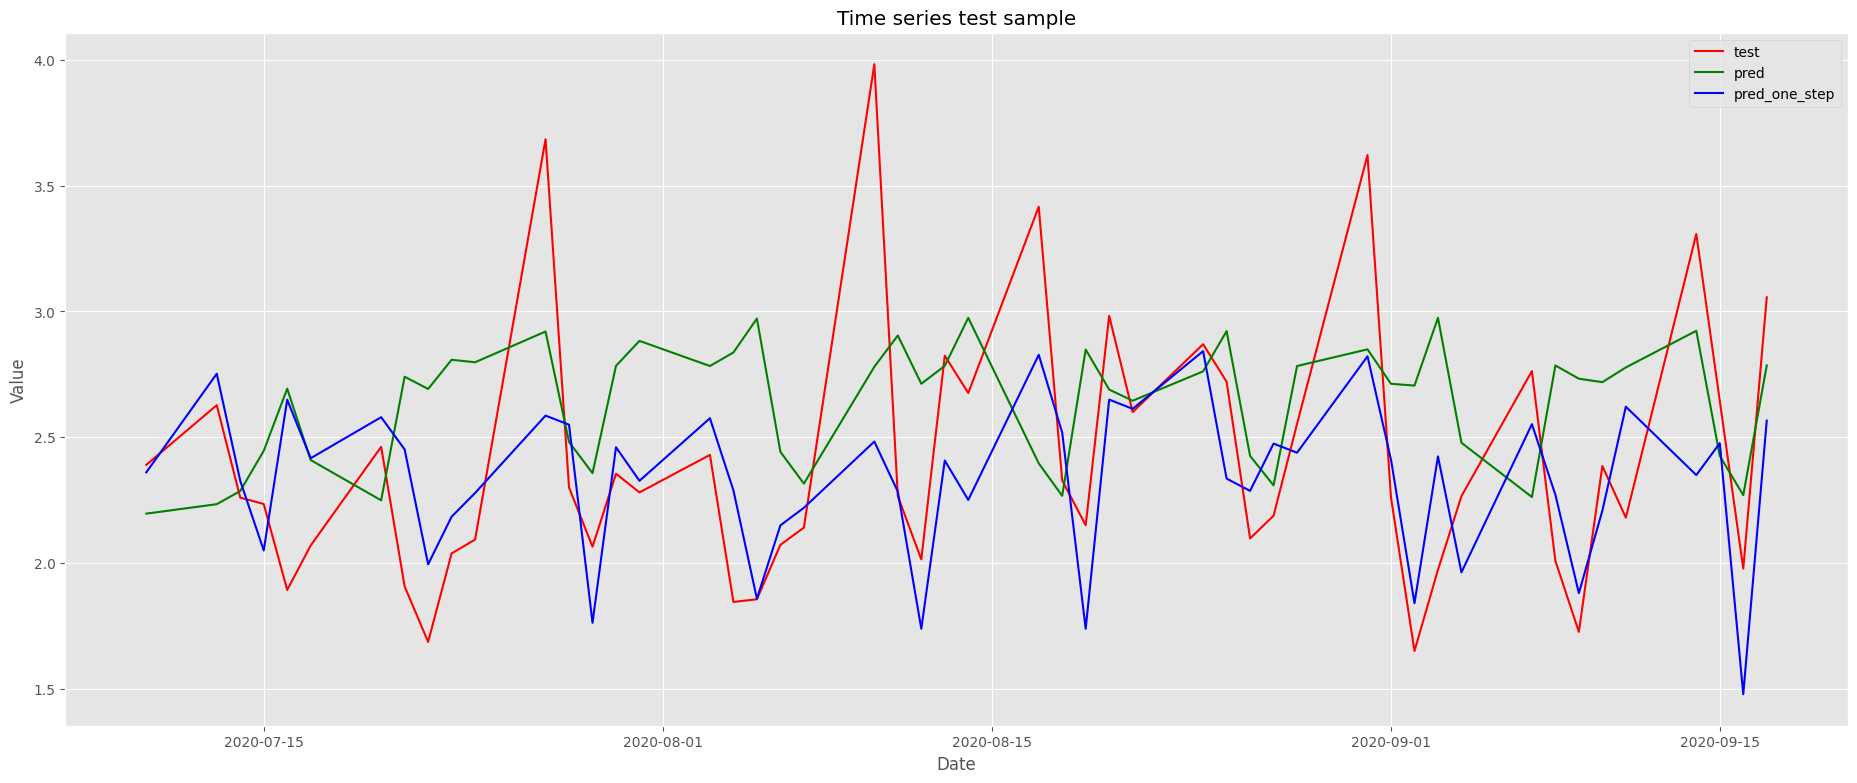

In [269]:
plt.plot(y_test.index, y_test.values, label = 'test', color = 'red')
plt.plot(y_test.index, y_pred, label = 'pred', color = 'green')
plt.plot(y_test.index, y_pred_one_step, label = 'pred_one_step', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

Рекурсивная похуже прогнозирует, чем одношаговая, при чем сильно

#### 5.3) Прямая стратегия (1 балла)
Внимание! Запрещается пользоваться готовыми функциями. Прямую стратегию необходимо написать вручную!

Реализуйте прямое прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [270]:
x_train_transformed.drop('remainder__date', axis =1, inplace = True)
x_test_transformed.drop('remainder__date', axis =1, inplace = True)

In [271]:
y_pred_dir = []
for lag in range(1, 51):
    ridge = Ridge()
    ridge.fit(x_train_transformed[:-lag], y_train[lag:])
    y_pred_dir.append(ridge.predict(x_train_transformed[-1:]).item())

In [272]:
y_pred_dir = pd.Series(y_pred_dir)
y_pred_dir.index = y_test.index
print('WAPE:', wape(y_test, y_pred_dir).item())


WAPE: 0.1557561810282308


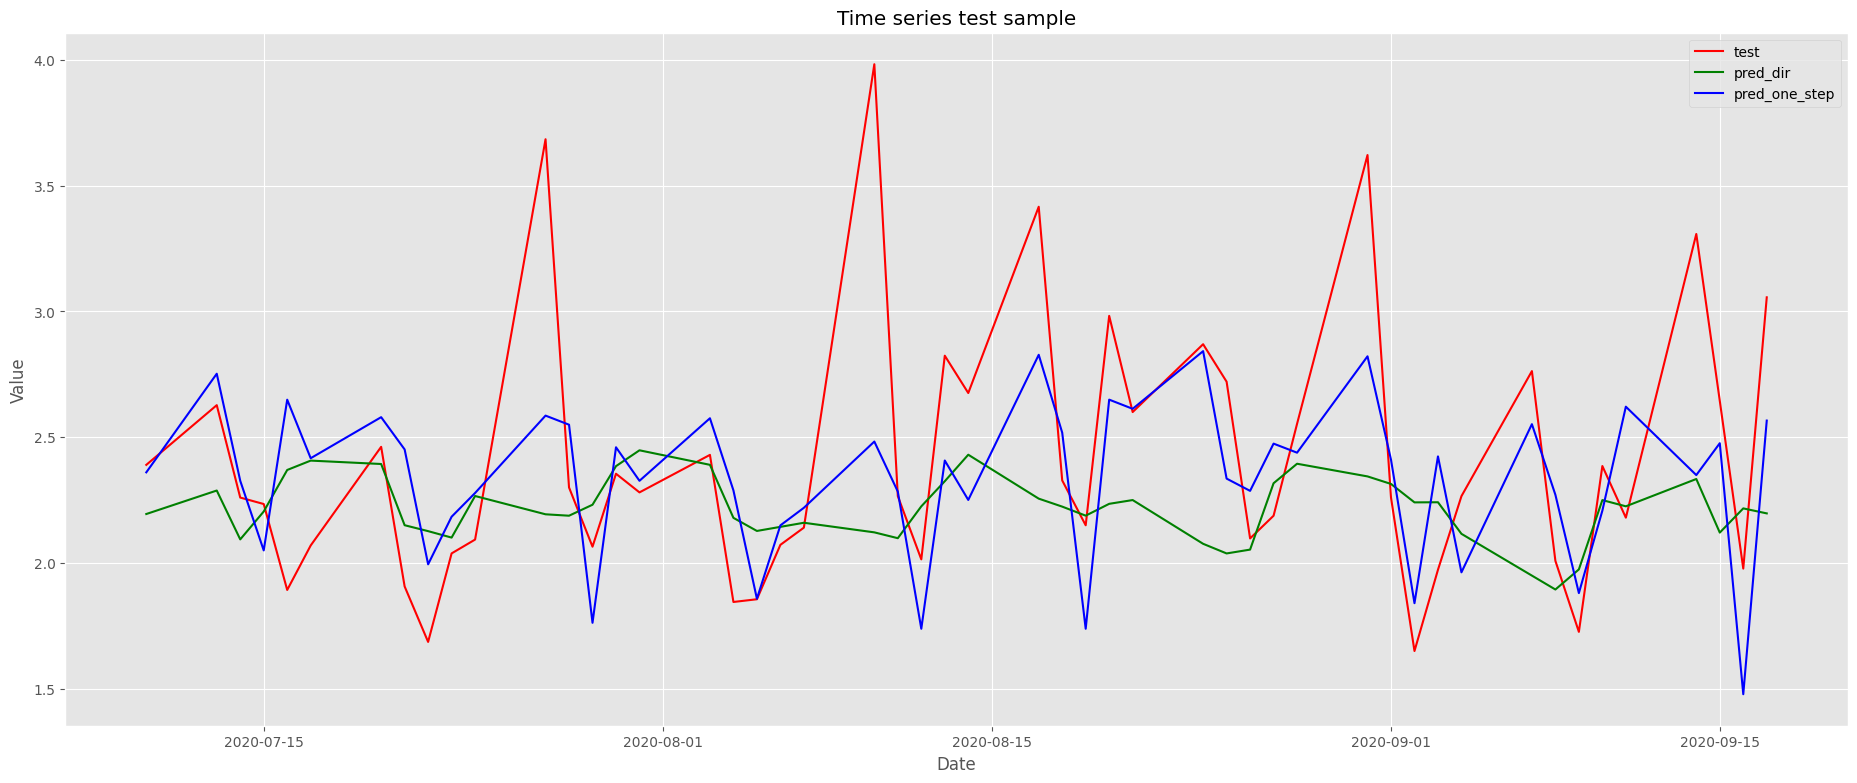

In [273]:
plt.plot(y_test.index, y_test.values, label = 'test', color = 'red')
plt.plot(y_test.index, y_pred_dir, label = 'pred_dir', color = 'green')
plt.plot(y_test.index, y_pred_one_step, label = 'pred_one_step', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

#### 5.4) Стратегия DirRec (1.5 балла)

Внимание! Запрещается пользоваться готовыми функциями. Стратегию необходимо написать вручную!

Реализуйте смешанное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [274]:
y_pred_dirrec = []
for lag in range(1, 51):
    ridge = Ridge()
    ridge.fit(x_train_transformed[:-lag], y_train[lag:])
    y_pred_train = ridge.predict(x_train_transformed)
    y_pred_dirrec.append(ridge.predict(x_train_transformed[-1:]).item())
    y_pred_train = pd.Series(y_pred_train)
    y_pred_train.name = f'Target_pred lag {lag}'
    
    x_train_transformed = pd.concat([x_train_transformed, pd.DataFrame(y_pred_train)], axis = 1)
    

In [278]:
y_pred_dirrec = pd.Series(y_pred_dirrec)
y_pred_dirrec.index = y_test.index
print('WAPE:', wape(y_test, y_pred_dirrec).item())

WAPE: 0.15656117403351547


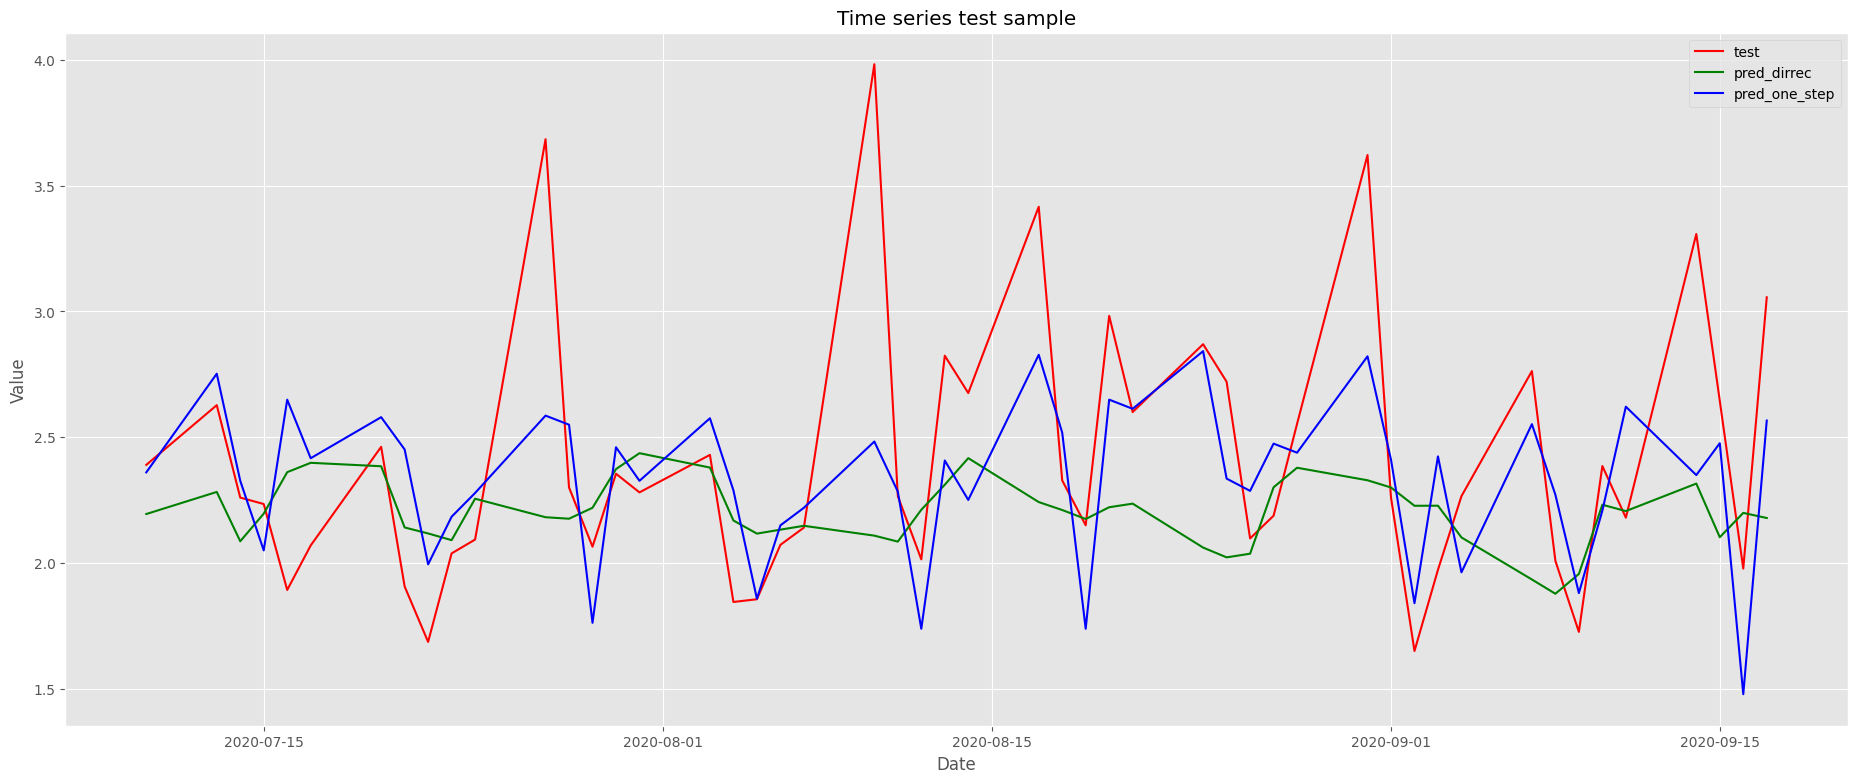

In [279]:
plt.plot(y_test.index, y_test.values, label = 'test', color = 'red')
plt.plot(y_test.index, y_pred_dirrec, label = 'pred_dirrec', color = 'green')
plt.plot(y_test.index, y_pred_one_step, label = 'pred_one_step', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

#### 5.5) Результаты (0.5 балла)

Визуализируйте прогнозы стратегий и тестовые данные на одном графике. Подсчитайте WAPE прогнозов. Какая оказалась лучше? Как вы думаете, почему?

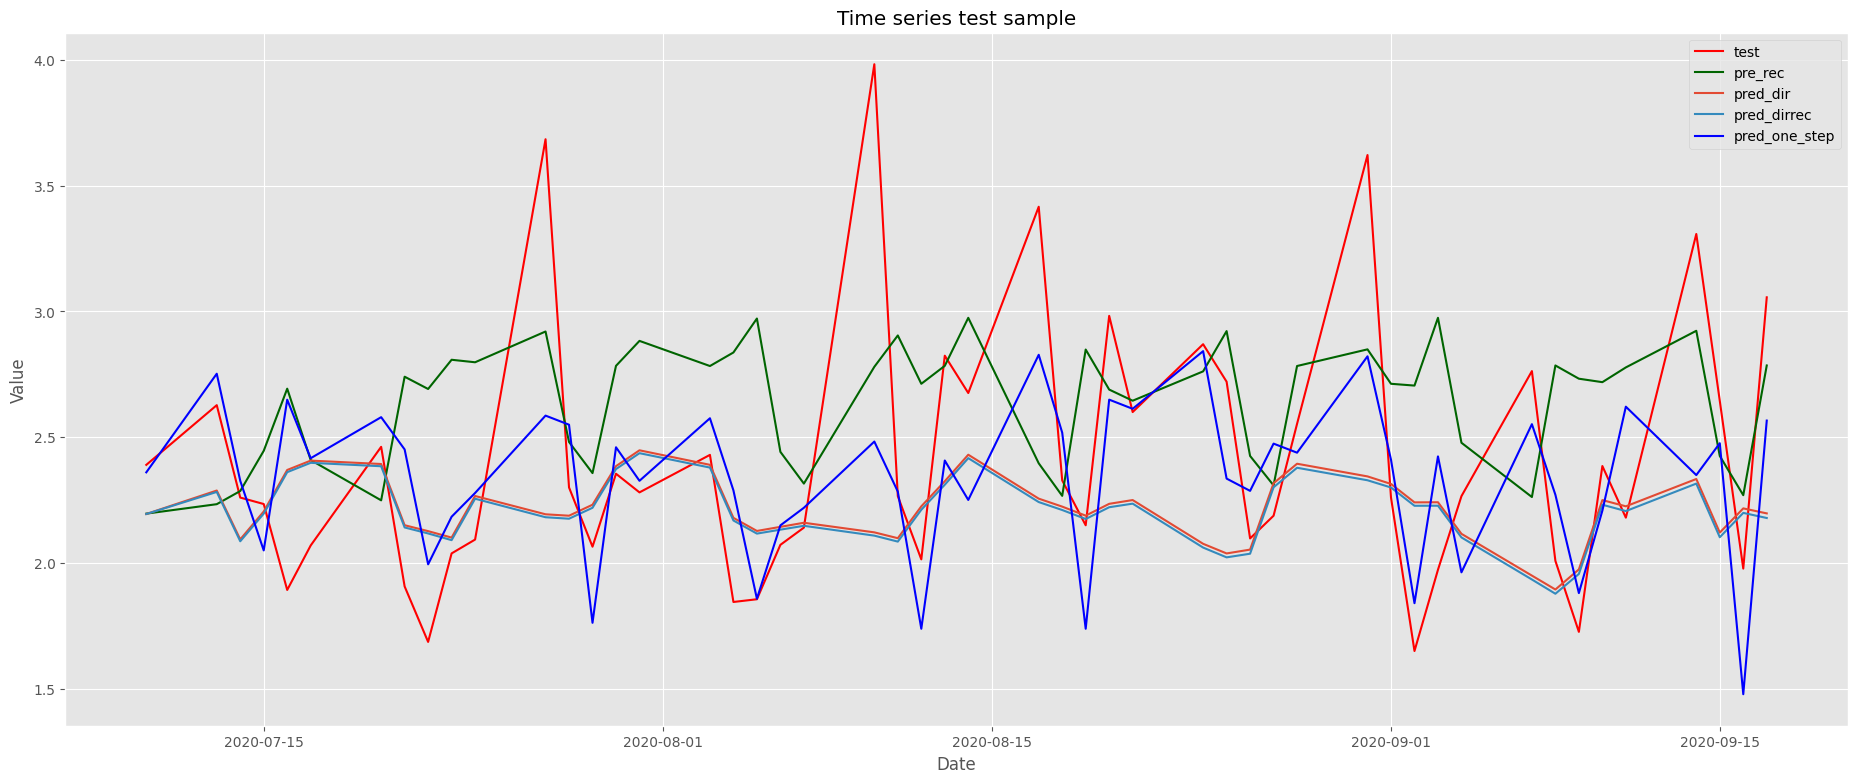

In [284]:
plt.plot(y_test.index, y_test.values, label = 'test', color = 'red')
plt.plot(y_test.index, y_pred, label = 'pre_rec', color = 'darkgreen')
plt.plot(y_test.index, y_pred_dir, label = 'pred_dir')
plt.plot(y_test.index, y_pred_dirrec, label = 'pred_dirrec')
plt.plot(y_test.index, y_pred_one_step, label = 'pred_one_step', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time series test sample')
plt.legend()
plt.show()

In [285]:
print('Model: Rec, WAPE:', wape(y_test, y_pred).item())
print('Model: Dir, WAPE:', wape(y_test, y_pred_dir).item())
print('Model: DirRec, WAPE:', wape(y_test, y_pred_dirrec).item())

Model: Rec, WAPE: 0.20487647274341678
Model: Dir, WAPE: 0.1557561810282308
Model: DirRec, WAPE: 0.15656117403351547


Лучше всего себя показал Dirrect метод прогнозирования

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/eKQTEKbYKD9YripL8

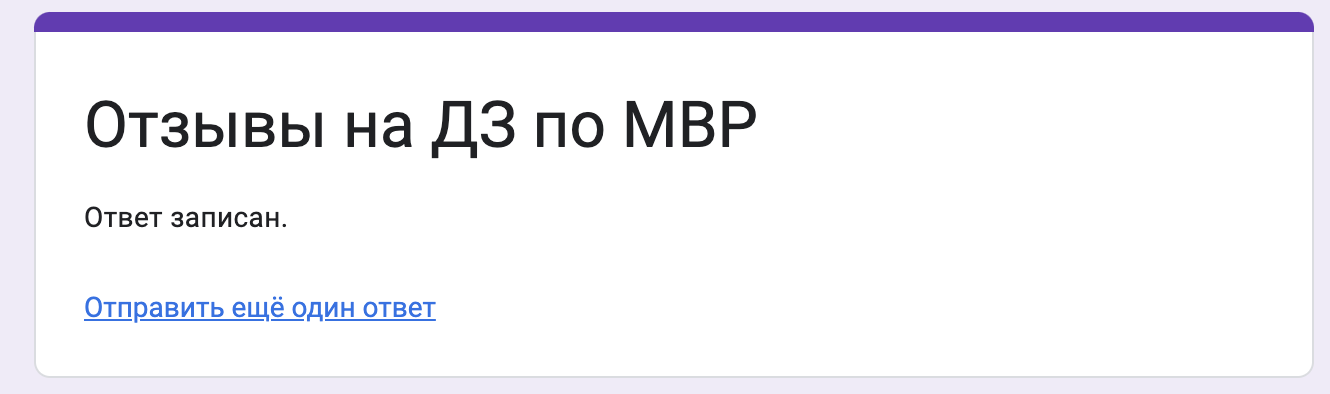